In [2]:
import soundfile as sf
import numpy as np
from scipy import stats
import matplotlib as plt
import torch
from fairseq.models.wav2vec import Wav2VecdecoderModel, Wav2VecAutoEncoderModel

## 1. Load Model

In [3]:
# ./w2v_thn/decoder/0118like_en_arch/checkpoint_last.pt
# './w2v_thn/0119_big_lr/checkpoint_best.pt'
# './w2v_thn/decoder/0119_big_lr_small_sample/checkpoint_last.pt'
cp = torch.load('./w2v_thn/decoder/0221_1_act_tanh_time_div4_feat8_6dB_MSE/checkpoint_best.pt')
cp = torch.load('./w2v_thn/FL_AutoEncoder/0302_tdiv1_feat2_10dB_MSE_local1P/checkpoint_last.pt')

model = Wav2VecAutoEncoderModel.build_model(cp['cfg']['model'], task=None)
model.load_state_dict(cp['model'])
model.eval()

Wav2VecAutoEncoderModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): ConvTranspose1d(2, 2, kernel_size=(1,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 2, eps=1e-05, affine=True)
      )
      (1): Sequential(
        (0): ConvTranspose1d(2, 2, kernel_size=(2,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 2, eps=1e-05, affine=True)
      )
      (2): Sequential(
        (0): ConvTranspose1d(2, 2, kernel_size=(4,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 2, eps=1e-05, affine=True)
      )
      (3): Sequential(
        (0): ConvTranspose1d(2, 1, kernel_size=(1,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Tanh()
      )
    )
  )
  (feature_aggregator): ConvAggegator(
    (conv_layers): Sequential(
      (0): Seq

In [4]:
Para = cp['model']

In [185]:
Para.keys()

odict_keys(['feature_extractor.conv_layers.0.0.weight', 'feature_extractor.conv_layers.0.2.weight', 'feature_extractor.conv_layers.0.2.bias', 'feature_extractor.conv_layers.1.0.weight', 'feature_extractor.conv_layers.1.2.weight', 'feature_extractor.conv_layers.1.2.bias', 'feature_extractor.conv_layers.2.0.weight', 'feature_extractor.conv_layers.2.2.weight', 'feature_extractor.conv_layers.2.2.bias', 'feature_extractor.conv_layers.3.0.weight', 'feature_extractor.conv_layers.3.2.weight', 'feature_extractor.conv_layers.3.2.bias', 'feature_extractor.conv_layers.4.0.weight', 'feature_extractor.conv_layers.4.2.weight', 'feature_extractor.conv_layers.4.2.bias', 'feature_extractor.conv_layers.5.0.weight', 'feature_extractor.conv_layers.5.2.weight', 'feature_extractor.conv_layers.5.2.bias', 'feature_extractor.conv_layers.6.0.weight', 'feature_aggregator.conv_layers.0.1.weight', 'feature_aggregator.conv_layers.0.1.bias', 'feature_aggregator.conv_layers.0.3.weight', 'feature_aggregator.conv_layers

In [190]:
Para['feature_extractor.conv_layers.5.0.weight']

tensor([[[0.5059]],

        [[0.3545]]], device='cuda:0', dtype=torch.float16)

#### 加载embedding

In [5]:
# import soundfile as sf
import numpy as np
from scipy import stats
import matplotlib as plt

fname = '/home/thn/audio_dataset/LibriSpeech/embedding_output/d0115/116-288045-0000.txt'
# sub_fame = fname.split('/')[-1].split('.')[0]
emb = np.loadtxt(fname)
feats = torch.from_numpy(emb).float().view(1, -1, 512).transpose(1, 2)

# wav, curr_sample_rate = sf.read(fname)
# feats = torch.from_numpy(wav).float()

###  加载音频

In [ ]:
import soundfile as sf
import numpy as np
from scipy import stats
import matplotlib as plt

fname = '/home/thn/audio_dataset/LibriSpeech/dev-other/116/288045/116-288045-0000.flac'
# fname = '/home/thn/audio_dataset/LibriSpeech/dev-clean/174/50561/174-50561-0000.flac'

wav, curr_sample_rate = sf.read(fname)
# feats = torch.from_numpy(wav).float()
wav_t = wav *5 /3 + 0.5
source = torch.from_numpy(wav).float().view(1, -1)

In [42]:
source.shape

torch.Size([1, 170400])

## 2. Pass model

In [ ]:
output = model(source)['out_audio']

In [ ]:
output['out_audio']

In [16]:
SNR = 6
import math
N = 0.2 /math.sqrt(10**(SNR/10))
N

0.10023744672545447

In [58]:
[r1,r2,r3] = X.shape
P_noise = 0.2 /math.sqrt(10**(SNR/10))
noise = np.random.randn(r1,r2,r3)
Y = X + torch.from_numpy(noise) * P_noise

In [62]:
type(torch.tensor(P_noise))

torch.Tensor

In [37]:
type(noise)

torch.Tensor

In [22]:
Y  = X + noise * torch.randn(X.shape)

In [1017]:
# Encoder, Transmitter 
source_ = source 
T_a = model.feature_extractor_en(source_)
T_a_ = model.dropout_feats_en(T_a)
print("|*****T_a_S:|", T_a_.shape)
X = model.feature_aggregator_en(T_a_)
X = model.dropout_agg_en(X)
print("|*******X_S:|", X.shape)

# Channel layer

import math
import numpy as np
SNR = 12 # dB # SNR = 10 log（s/n） = 6
P_noise = 0.2 /math.sqrt(10**(SNR/10))
P_noise = torch.tensor(P_noise).half()
# [r1,r2,r3] = X.shape 
# noise = np.random.randn(r1,r2,r3)
noise = torch.randn(X.shape).half()
# print(X.type(), torch.from_numpy(noise).float().cuda().type(), P_noise.type())
# Y = X + torch.from_numpy(noise).half().cuda() * P_noise.cuda()
Y = X + noise * P_noise

# —————————— No Noise Channel ————————-
# Y  = X

# ——————————  Decoder, Receiver ———————
print("In the Channel Y_S", Y.shape)
features = model.feature_aggregator(Y)
# x = self.dropout_agg(feature)

features_ = model.dropout_agg(features)
x = model.feature_extractor(features_)
print("|in decoder model, out feature_extractor|", x.shape)
x_ = model.dropout_feats(x)
# x_ = x_ - 1

|*****T_a_S:| torch.Size([1, 2, 170396])
|*******X_S:| torch.Size([1, 2, 170396])
In the Channel Y_S torch.Size([1, 2, 170396])
x_Shape_in_extractor: torch.Size([1, 2, 170396])
x_Shape_out_extractor: torch.Size([1, 1, 170400])
|in decoder model, out feature_extractor| torch.Size([1, 1, 170400])


In [4]:
plot_curve((x_.view(-1)).detach().numpy())# original output

NameError: name 'plot_curve' is not defined

In [1]:
NRMSE(x_[:,:,:] * 1.1, source) # no noise

NameError: name 'NRMSE' is not defined

##### Dissolution Aggregatror Experiment

In [322]:
# Encoder, Transmitter 
source_ = source 
T_a = model.feature_extractor_en(source_)
T_a_ = model.dropout_feats_en(T_a)
print("|*****T_a_S:|", T_a_.shape)
# X = model.feature_aggregator_en(T_a_)
# X = model.dropout_agg_en(X)
print("|*******X_S:|", X.shape)

# Channel layer

import math
import numpy as np
SNR = 8  # dB # SNR = 10 log（s/n） = 6
P_noise = 0.2 /math.sqrt(10**(SNR/10))
P_noise = torch.tensor(P_noise).half()
# [r1,r2,r3] = X.shape 
# noise = np.random.randn(r1,r2,r3)
noise = torch.randn(T_a_.shape).half()
# print(X.type(), torch.from_numpy(noise).float().cuda().type(), P_noise.type())
# Y = X + torch.from_numpy(noise).half().cuda() * P_noise.cuda()
Y = T_a_ + noise * P_noise

# Y  = X
# Decoder, Receiver
print("In the Channel Y_S", Y.shape)
# features = model.feature_aggregator(Y)
# x = self.dropout_agg(feature)

# features_ = model.dropout_agg(features)
x = model.feature_extractor(Y)
print("|in decoder model, out feature_extractor|", x.shape)
x_ = model.dropout_feats(x)
# x_ = x_ - 1

|*****T_a_S:| torch.Size([1, 32, 170396])
|*******X_S:| torch.Size([1, 32, 170396])
In the Channel Y_S torch.Size([1, 32, 170396])
x_Shape_in_extractor: torch.Size([1, 32, 170396])
x_Shape_out_extractor: torch.Size([1, 1, 170403])
|in decoder model, out feature_extractor| torch.Size([1, 1, 170403])


In [130]:
model.feature_extractor.log_compression = False

In [ ]:
model.feature_extractor.conv_layers

In [15]:
op_0 = model.feature_extractor_en.conv_layers[0](source_.unsqueeze(0))
op_1 = model.feature_extractor_en.conv_layers[1](op_0)
op_2 = model.feature_extractor_en.conv_layers[2](op_1)
op_3 = model.feature_extractor_en.conv_layers[3](op_2)
# op_4 = model.feature_extractor_en.conv_layers[4](op_3)
# op_5 = model.feature_extractor.conv_layers[5](op_4)
# op_6 = model.feature_extractor.conv_layers[6](op_5)
# op_7 = model.feature_extractor.conv_layers[7](op_6)


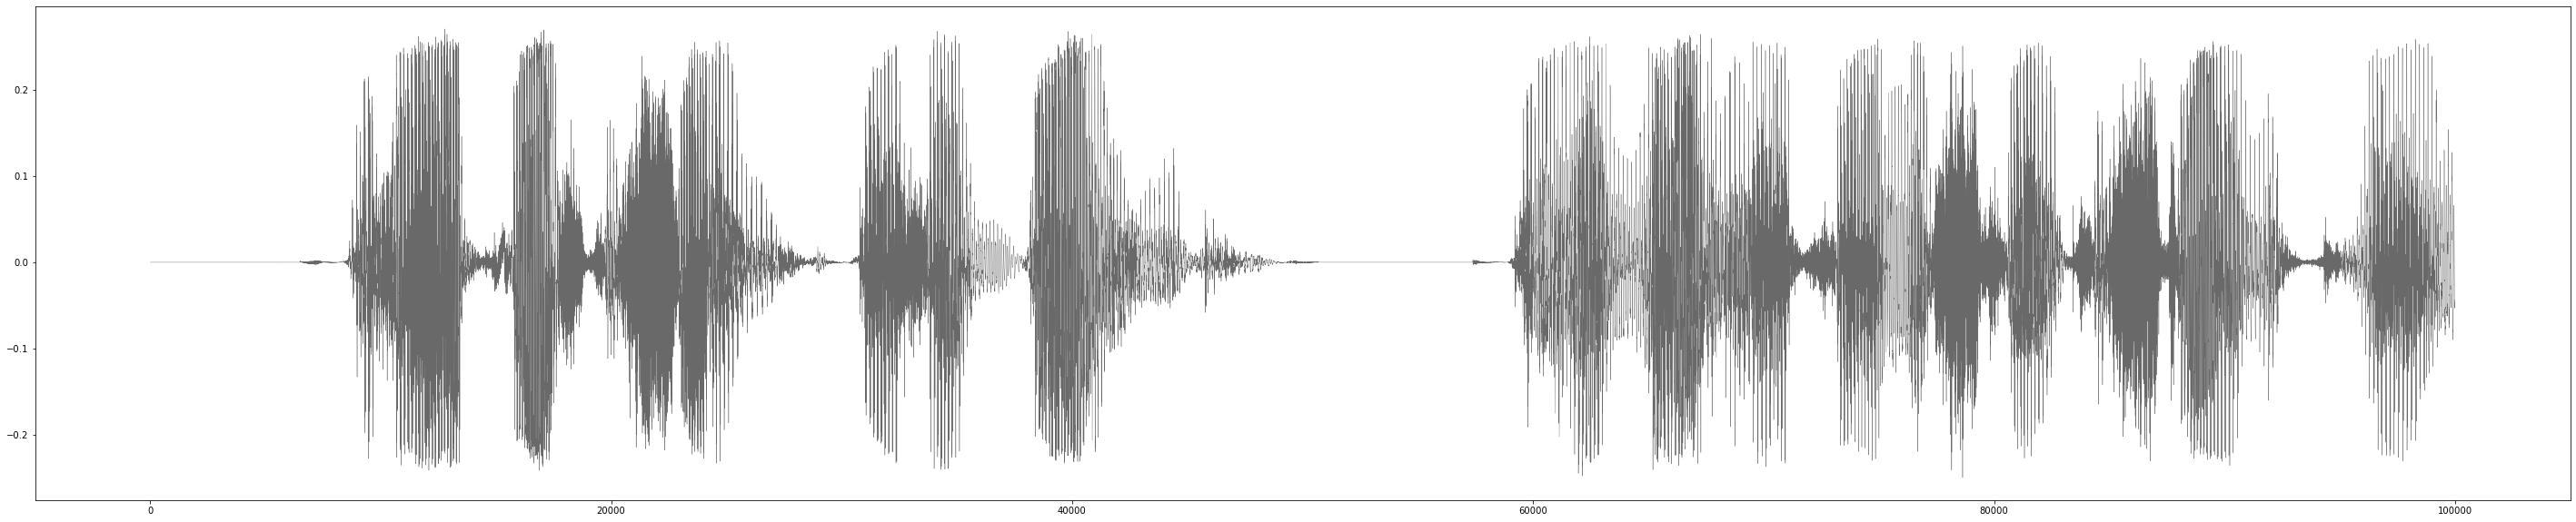

In [16]:
plot_curve((source_.view(-1)[:100000]).detach().numpy())

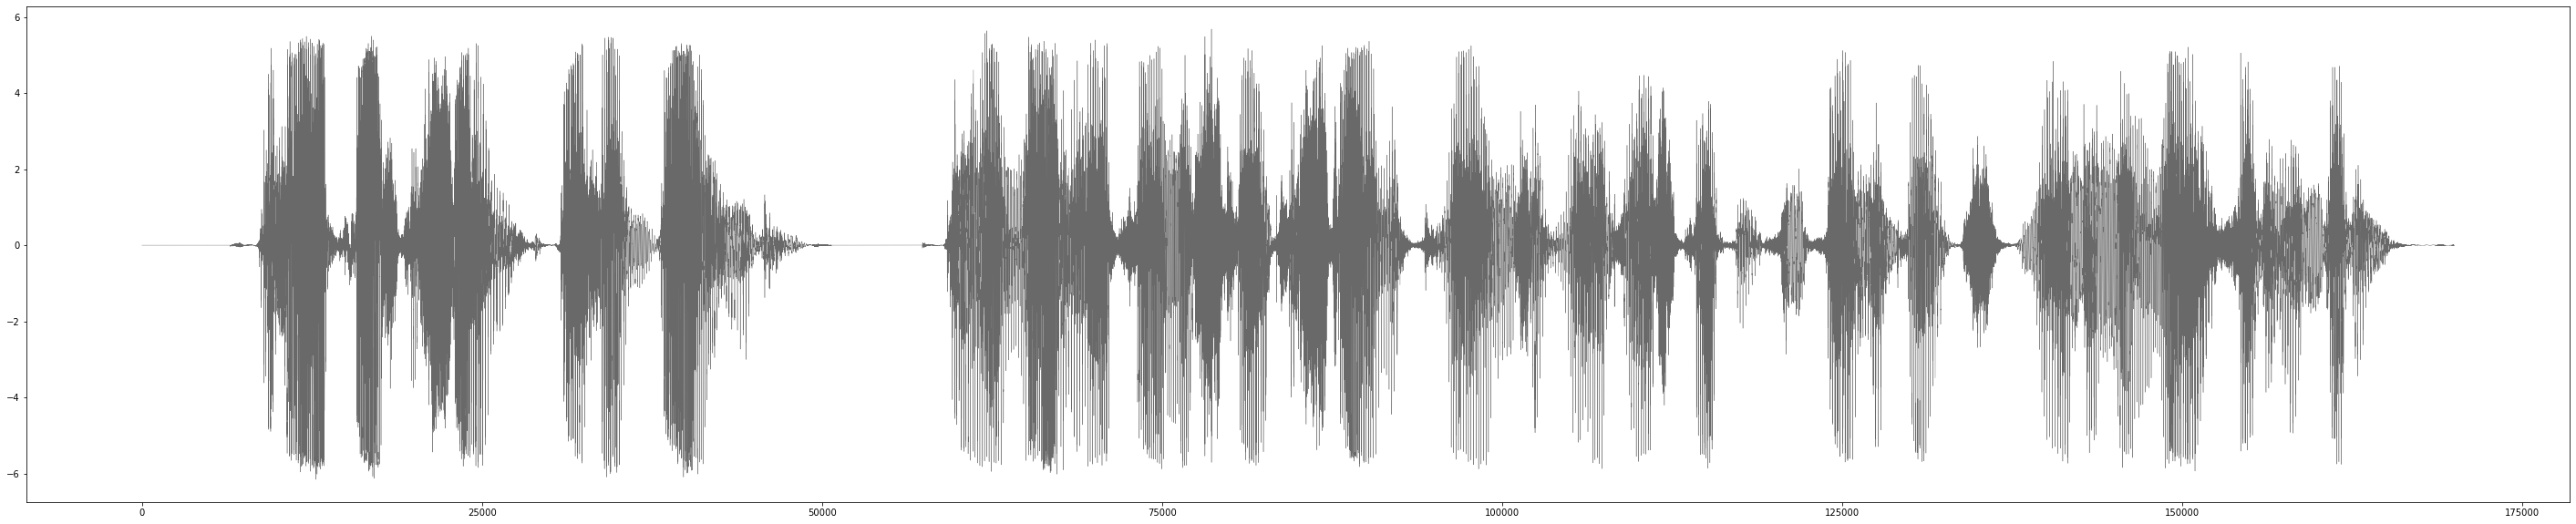

In [19]:
plot_curve((op_0.view(-1)[:170000]).detach().numpy())

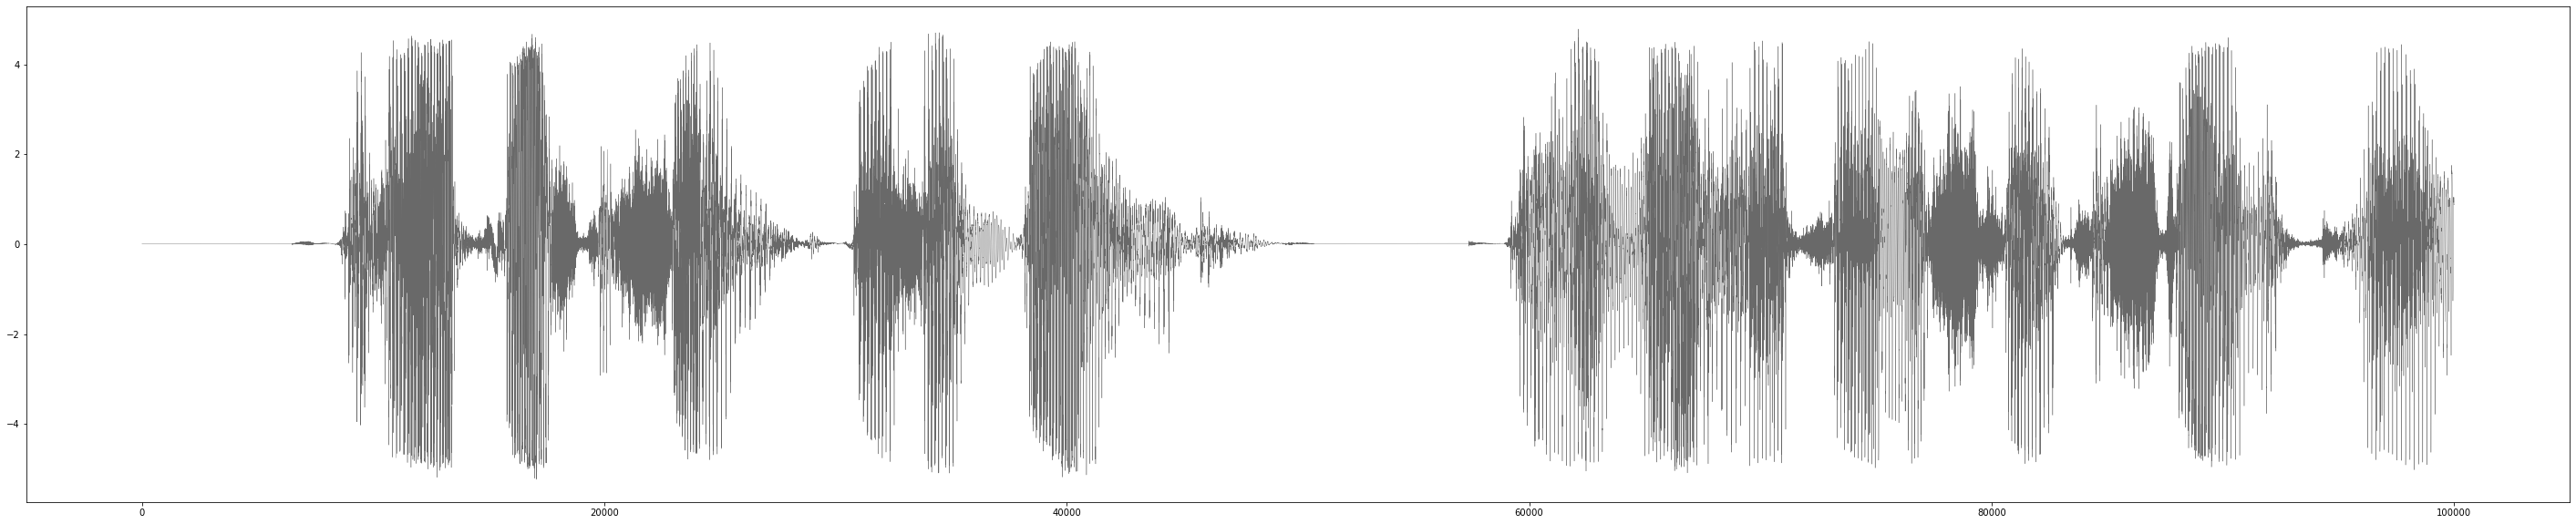

In [20]:
plot_curve((op_1.view(-1)[:100000]).detach().numpy())

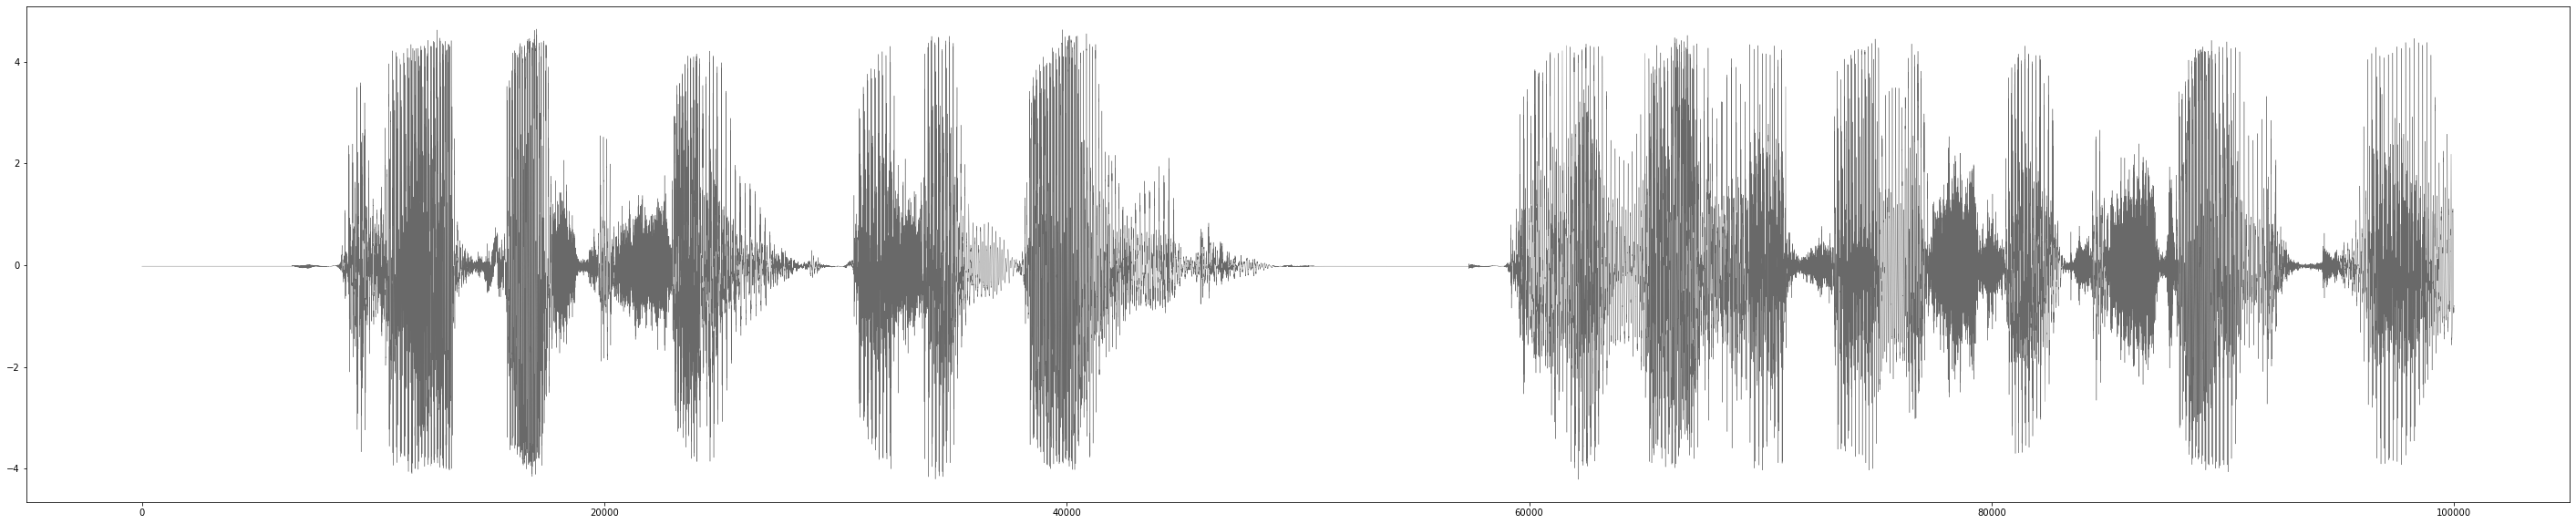

In [21]:
plot_curve((op_2.view(-1)[:100000]).detach().numpy())

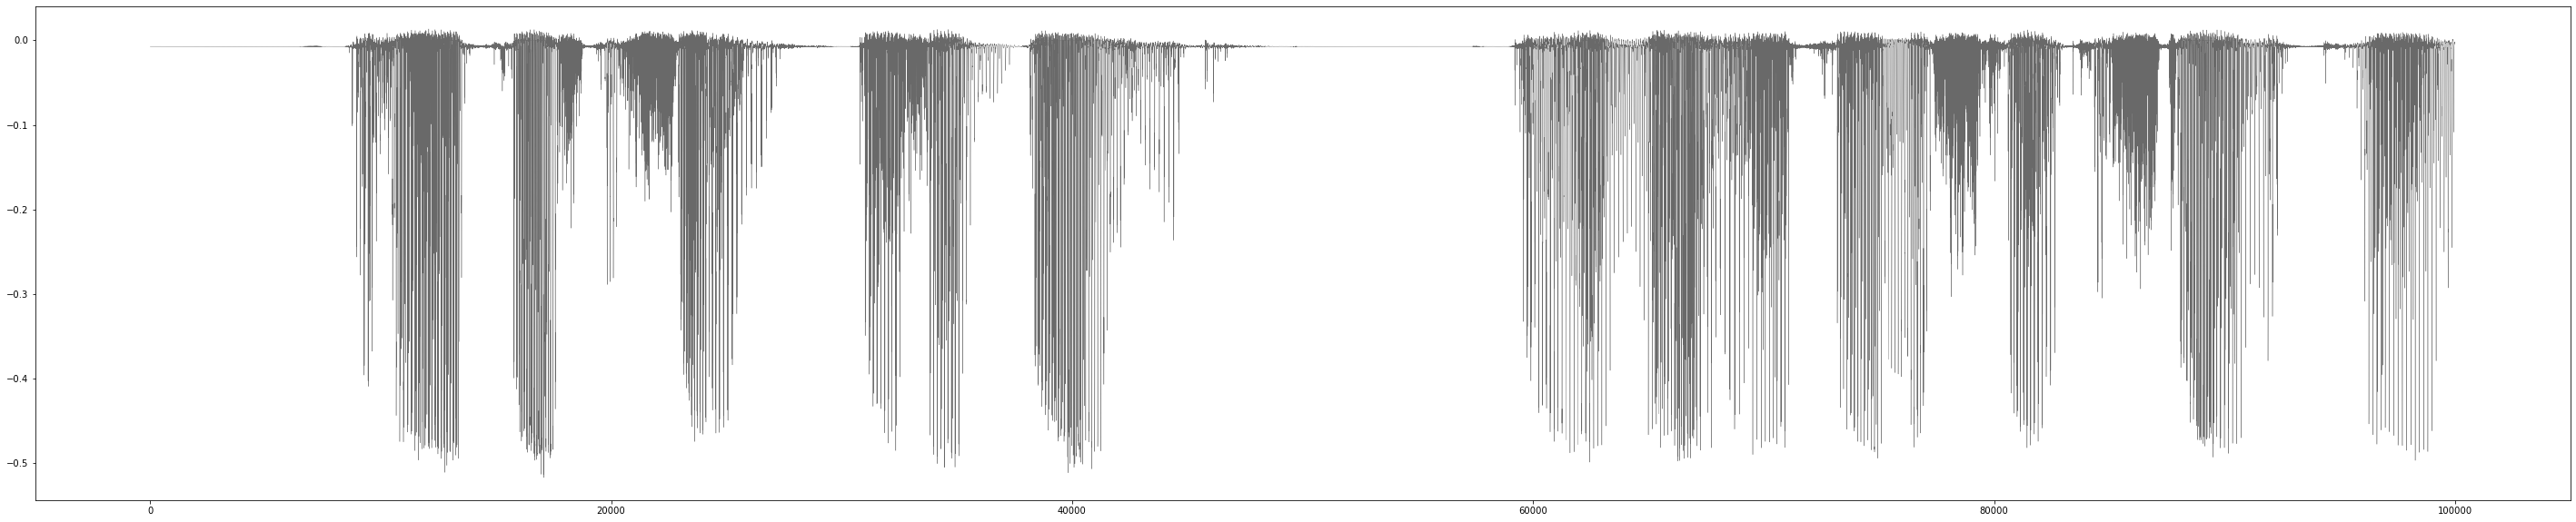

In [59]:
plot_curve((op_3.view(-1)[:100000]).detach().numpy())

In [49]:
plot_curve((op_4.view(-1)[:100000]).detach().numpy())

NameError: name 'op_4' is not defined

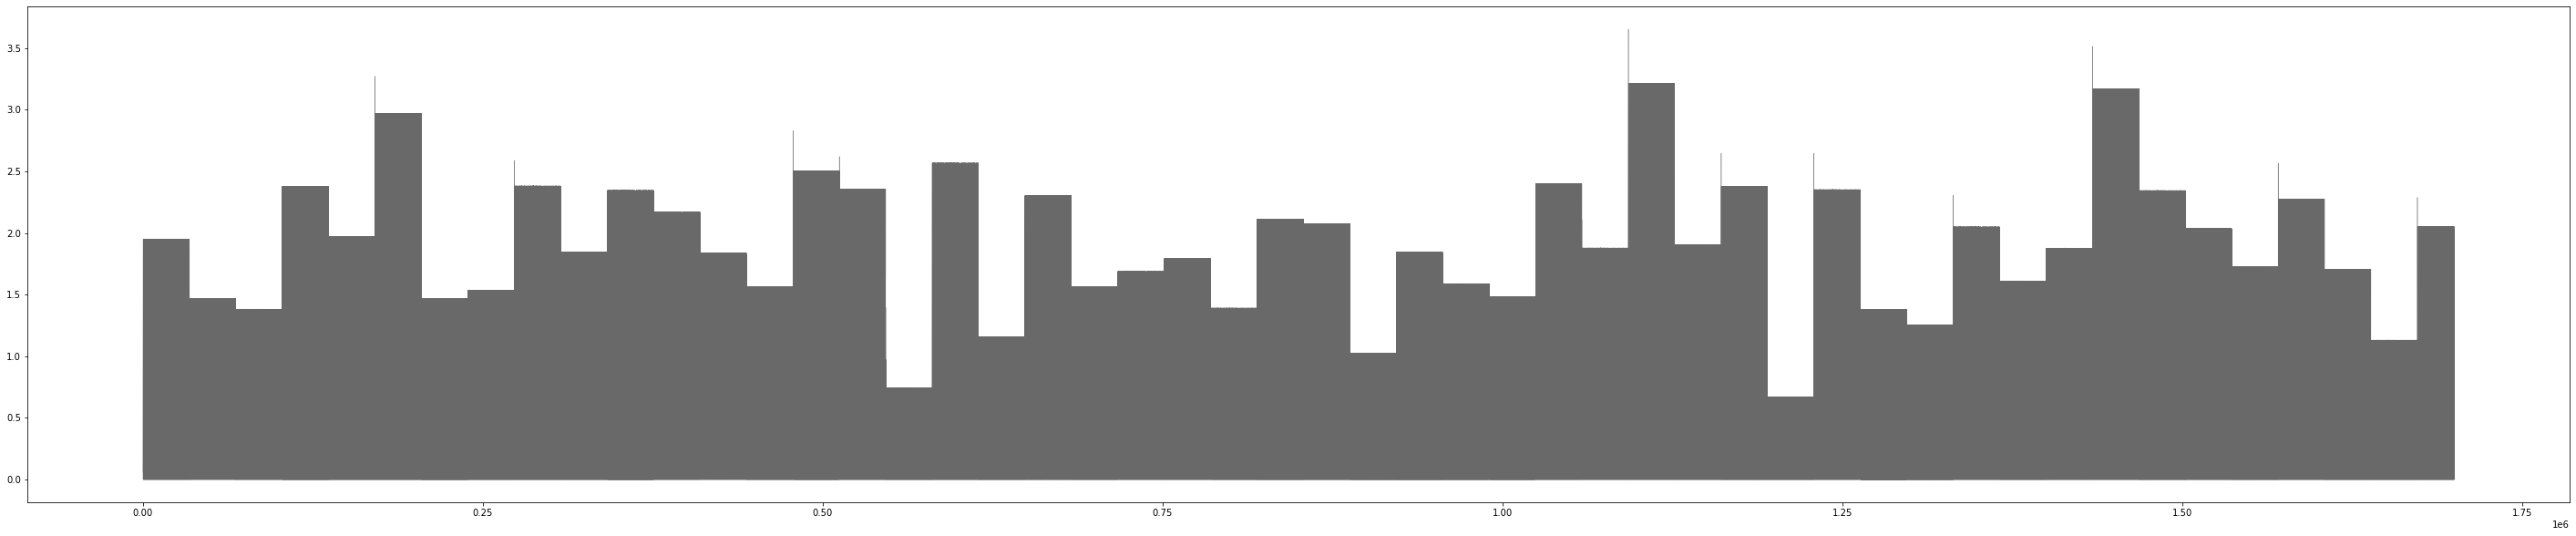

In [22]:
plot_curve((op_5.view(-1)[:1700000]).detach().numpy())

In [ ]:
plot_curve((op_6.view(-1)[:100000]).detach().numpy())

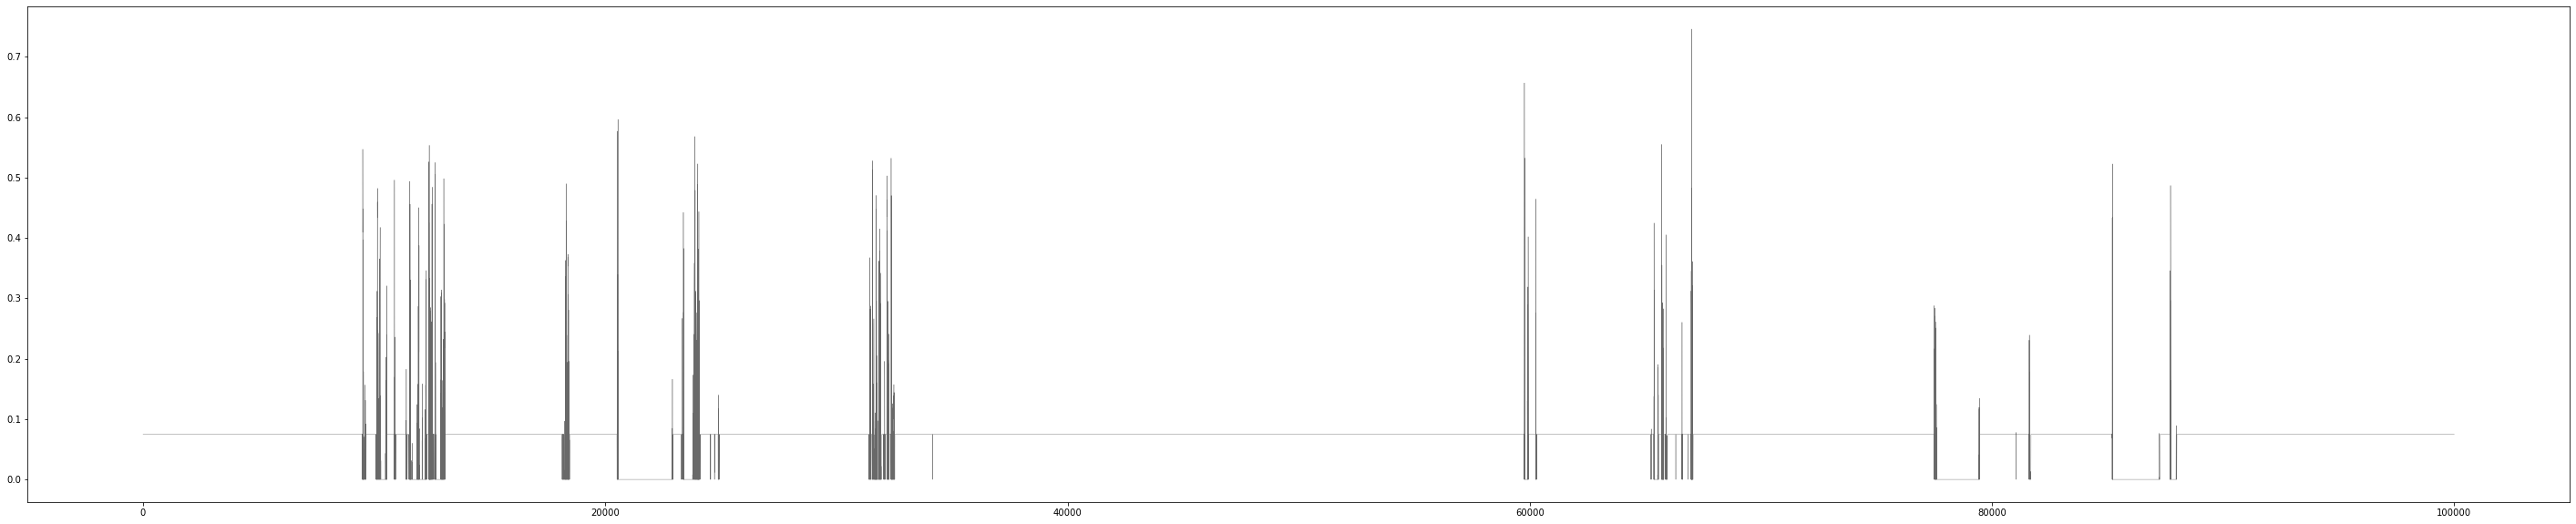

In [10]:
plot_curve(((x_).view(-1)[:100000]).detach().numpy())

In [87]:
x.shape

torch.Size([1, 1, 170705])

In [54]:
x.min()

tensor(2.3842e-07, grad_fn=<MinBackward1>)

In [ ]:
model.feature_extractor_en

In [10]:
z_ = model.feature_aggregator(feats)
z = model.dropout_agg(z_)
c_ = model.feature_extractor(z)
x = model.dropout_feats(c_)

x_Shape_in_extractor: torch.Size([1, 512, 1063])
x_Shape_out_extractor: torch.Size([1, 1, 172007])


In [ ]:
import matplotlib.pyplot as plt
 
# 随意绘制一个样图
plt.plot([1,2,3,4,3,2,3])
 
# 保存图为svg格式，即矢量图格式
plt.savefig("test.eps")


In [594]:
#  定义绘制一维向量的函数
def plot_curve(y: np.ndarray, i = 0, j = 0) -> None:
    import matplotlib.pyplot as plt
    import matplotlib
    x = np.arange(0,len(y))
    if j == 0: 
        j = len(y)      
    # i = 10000
    # l = 50000
    plt.figure(1)
    plt.plot(x[i: i + j], y[i: i + j],'k',color='#696969', linewidth=0.4, linestyle="-") 
    plt.rcParams['figure.figsize'] = (50.0, 10.0) # 设置figure_size尺寸
    plt.grid(ls='--')#标尺，on：有，off:无。
#     plt.savefig('fig_source.eps', dpi=600, format='eps')
#     plt.savefig('fig_source.png')
    plt.show() #展示绘图


In [617]:
#  定义绘制一维向量的函数
def save_curve(y: np.ndarray, fig_name: str) -> None:
    import matplotlib.pyplot as plt
    import matplotlib
    i = 0
    j = 0
    x = np.arange(0,len(y))
    if j == 0: 
        j = len(y)      
    # i = 10000
    # l = 50000
    plt.figure(1)
    plt.plot(x[i: i + j], y[i: i + j],'k',color='#696969', linewidth=0.4, linestyle="-") 
    plt.rcParams['figure.figsize'] = (25.0, 10.0) # 设置figure_size尺寸
    plt.grid(ls='--')#标尺，on：有，off:无。
    
#     plt.title('显示中文标题') 标题
    plt.xlabel("Time samples", fontsize=20)
#     plt.xticks(fontsize=15)

    plt.ylabel("Value", fontsize=20)
#     plt.yticks(fontsize=15,fontsize=15)

    plt.savefig(fig_name, dpi=600, format='eps')
#     plt.savefig('fig_source.png')
#     plt.show() #展示绘图


## 3. Plot Fig

In [321]:
NRMSE(x_[:,:,:] * 2, source) # no noise

output, source, minlen= 170403 170400 170400
tensor(0.0001, grad_fn=<MseLossBackward>)


tensor(0.0001, grad_fn=<MseLossBackward>)

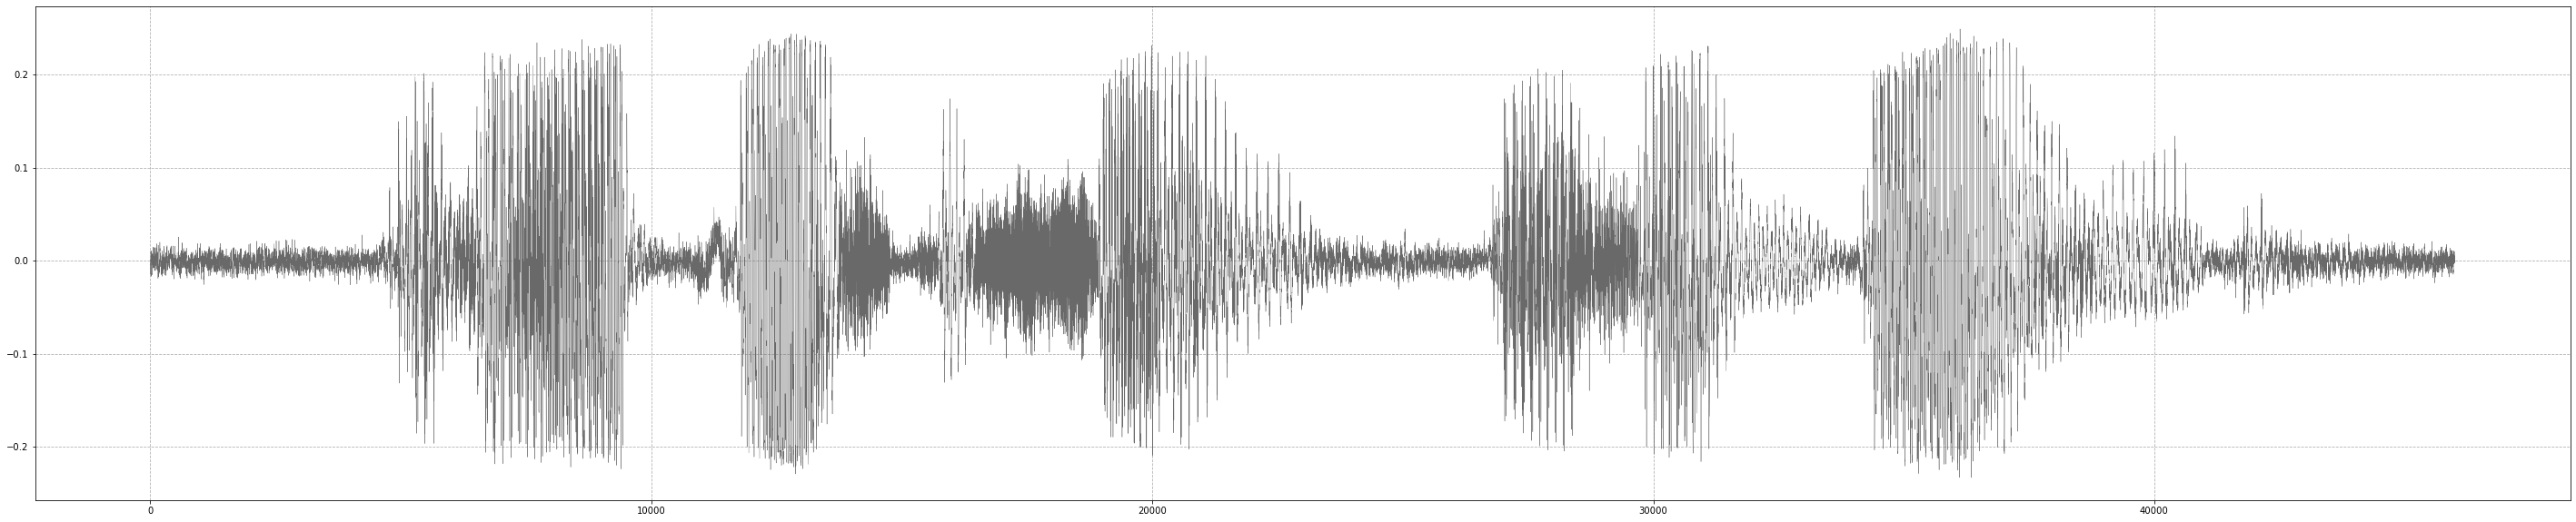

In [627]:
plot_curve((x_.view(-1)[4000:50000]*2).detach().numpy())    # original output

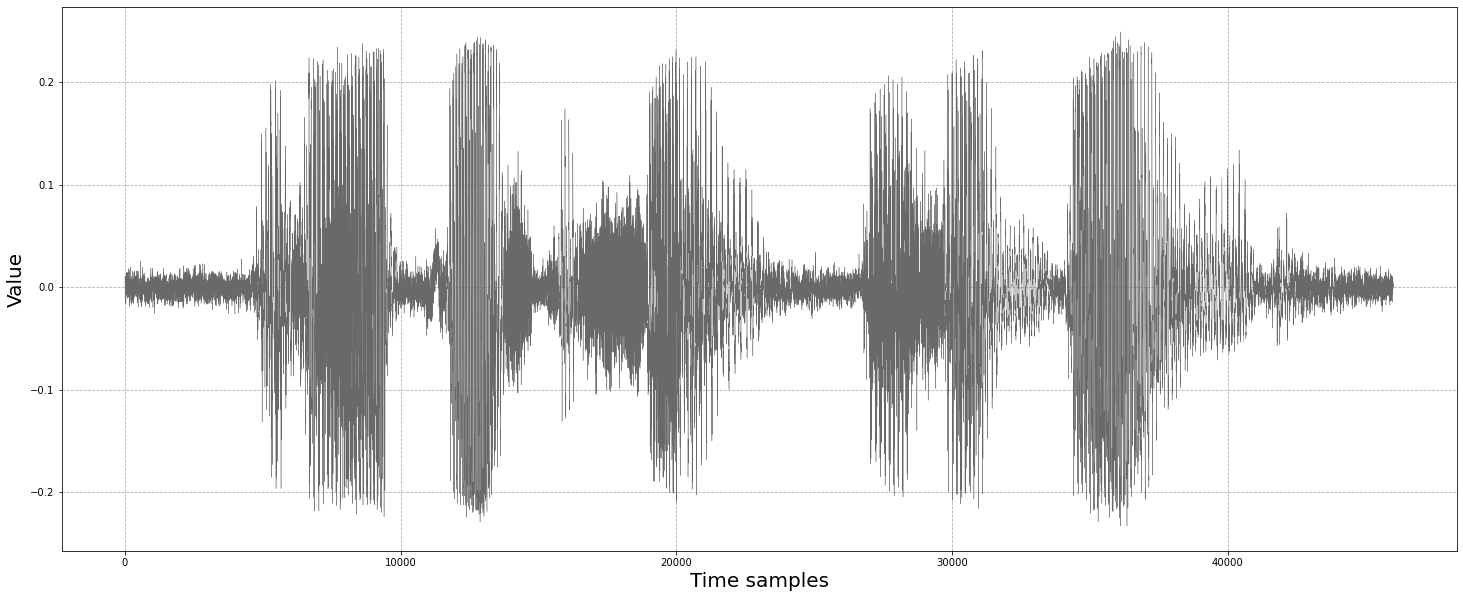

In [632]:
save_curve((x_.view(-1)[4000:50000]*2).detach().numpy(), 'fig_decoded.eps')    # original output

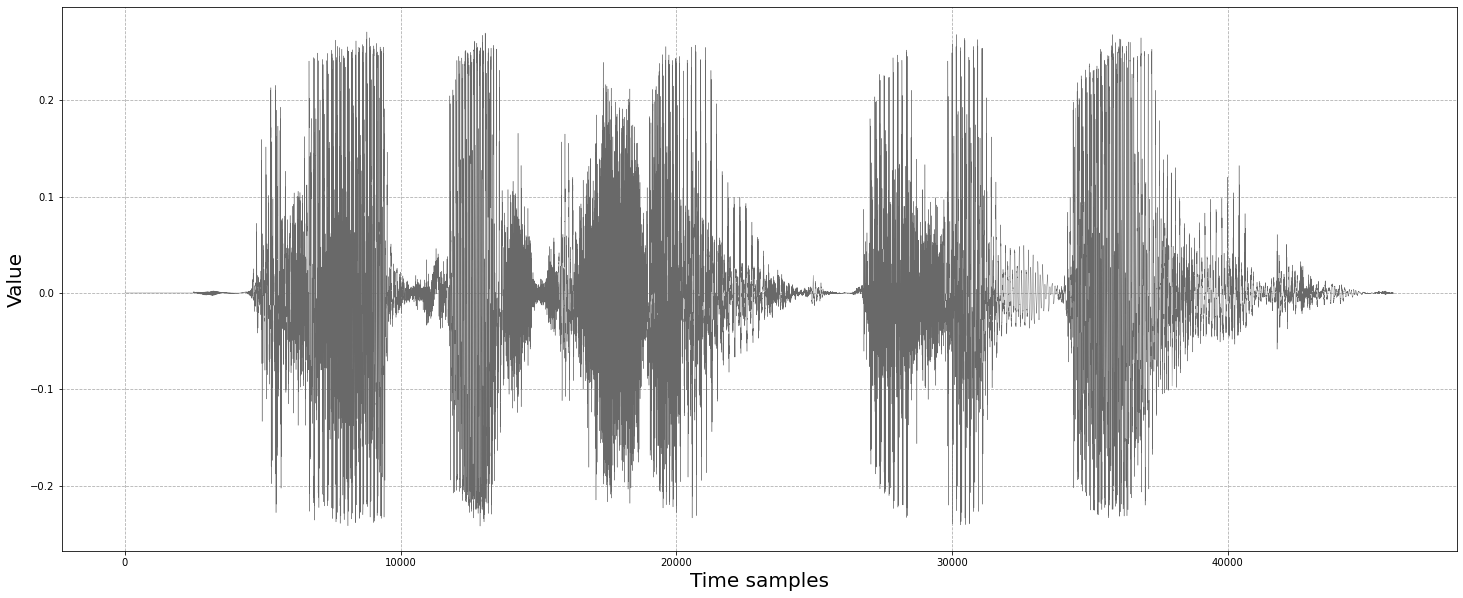

In [633]:
save_curve((source.view(-1)[4000:50000]).detach().numpy(), 'fig_source.eps')

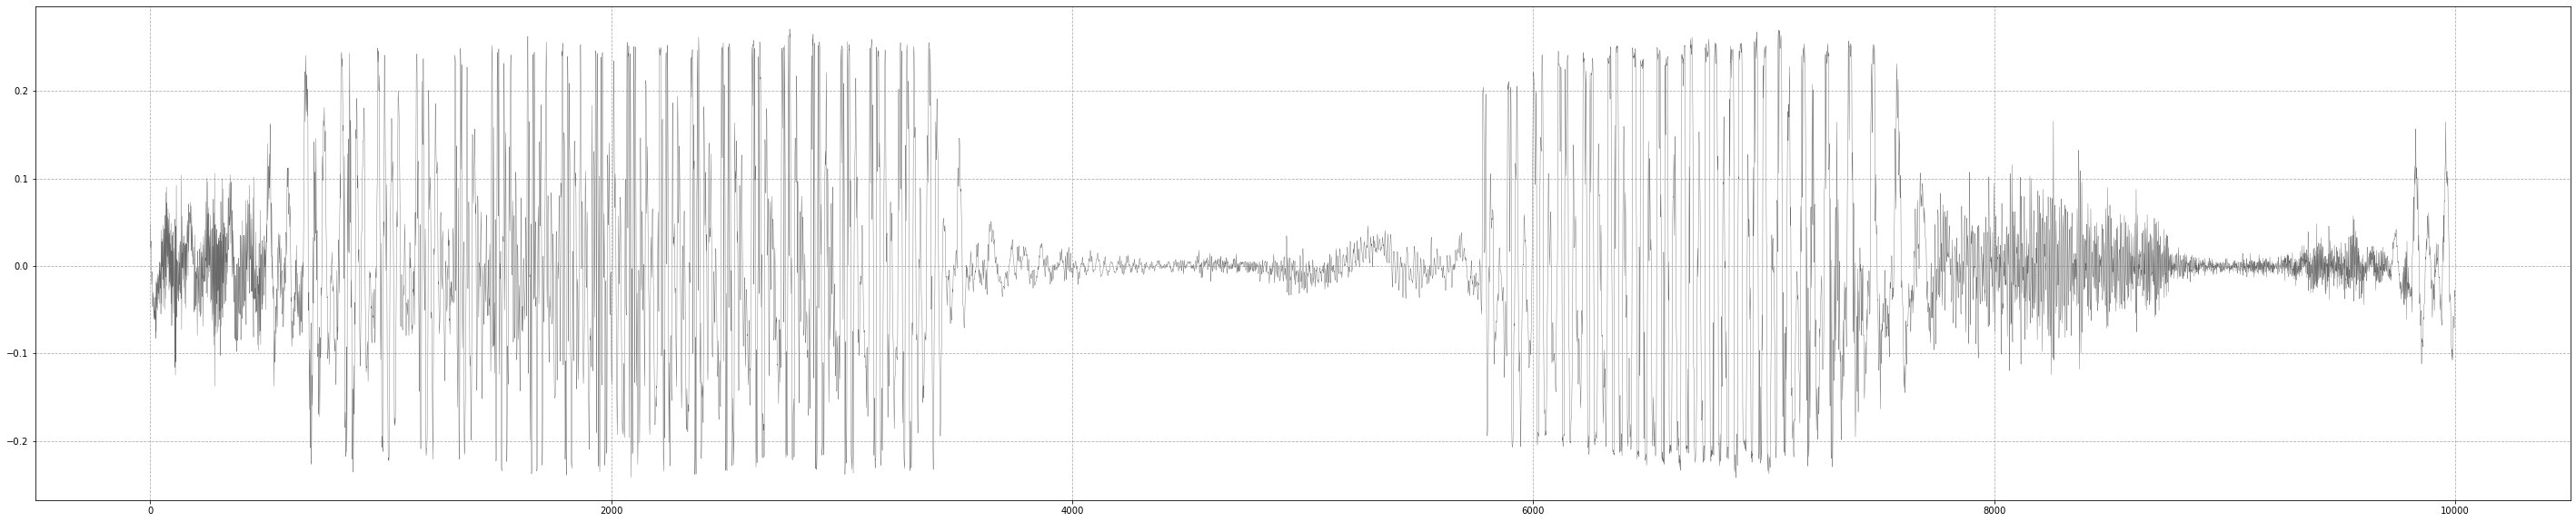

In [595]:
plot_curve((source.view(-1)[10000:20000]).detach().numpy())

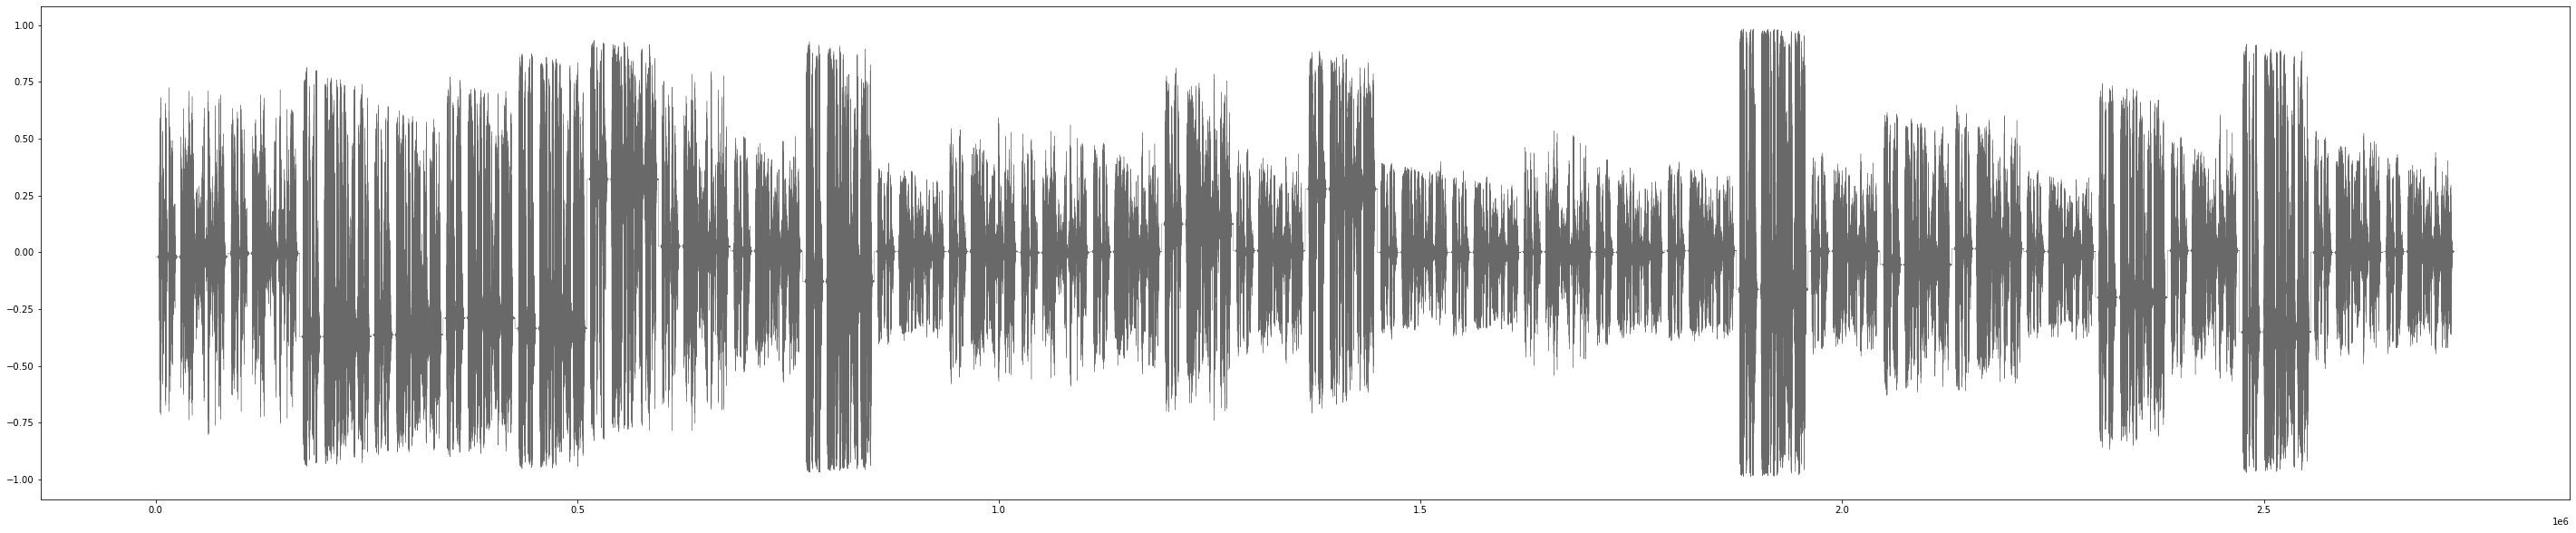

In [94]:
plot_curve((T_a_.view(-1)).detach().numpy())     # dissolution exp

### 4. View output

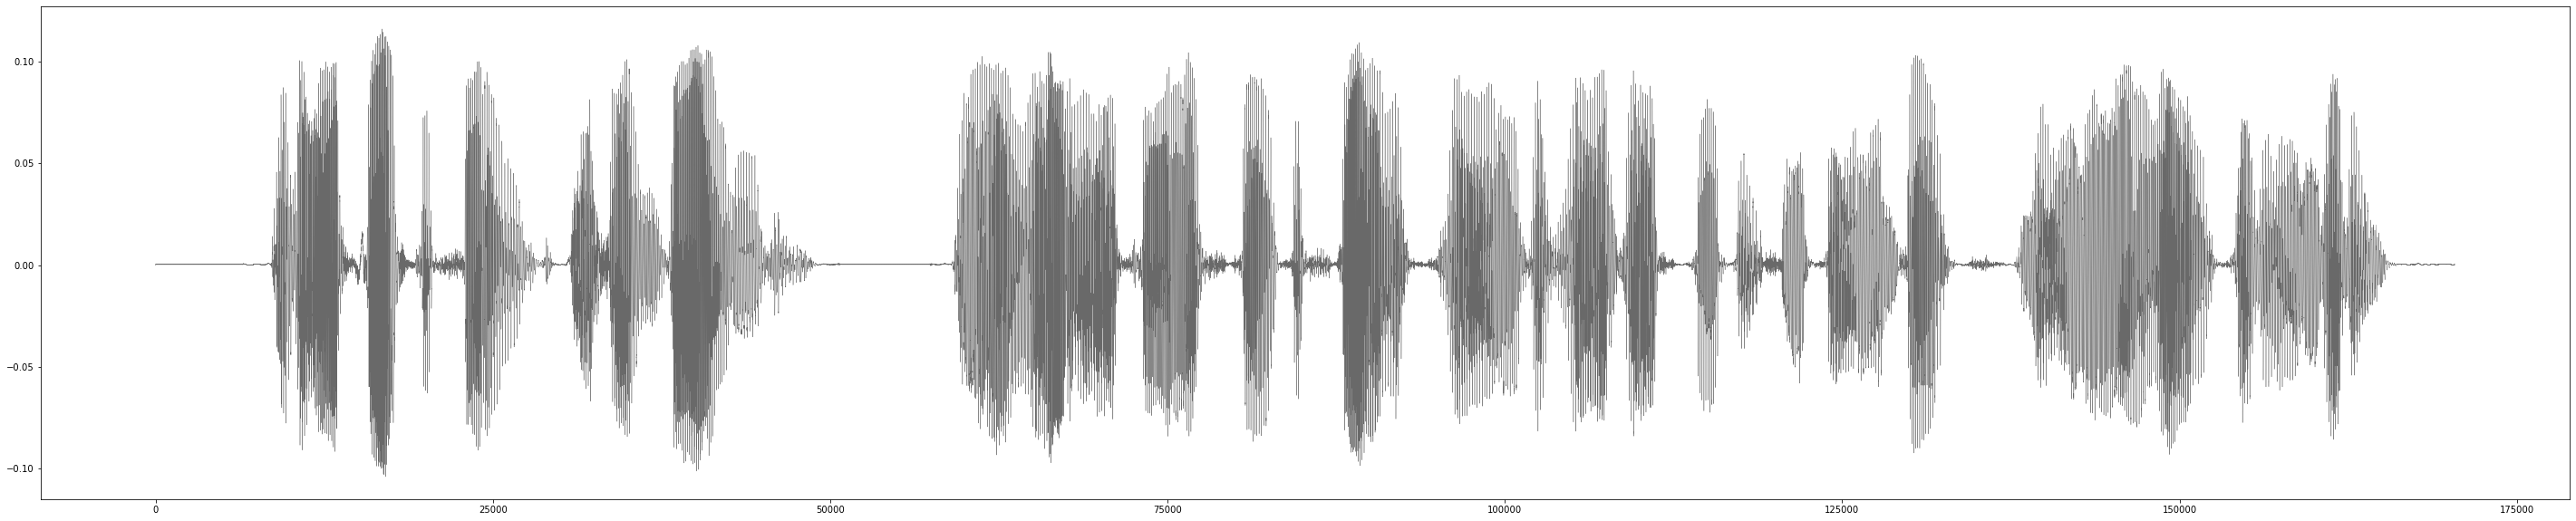

In [25]:
plot_curve((output.view(-1)).detach().numpy())

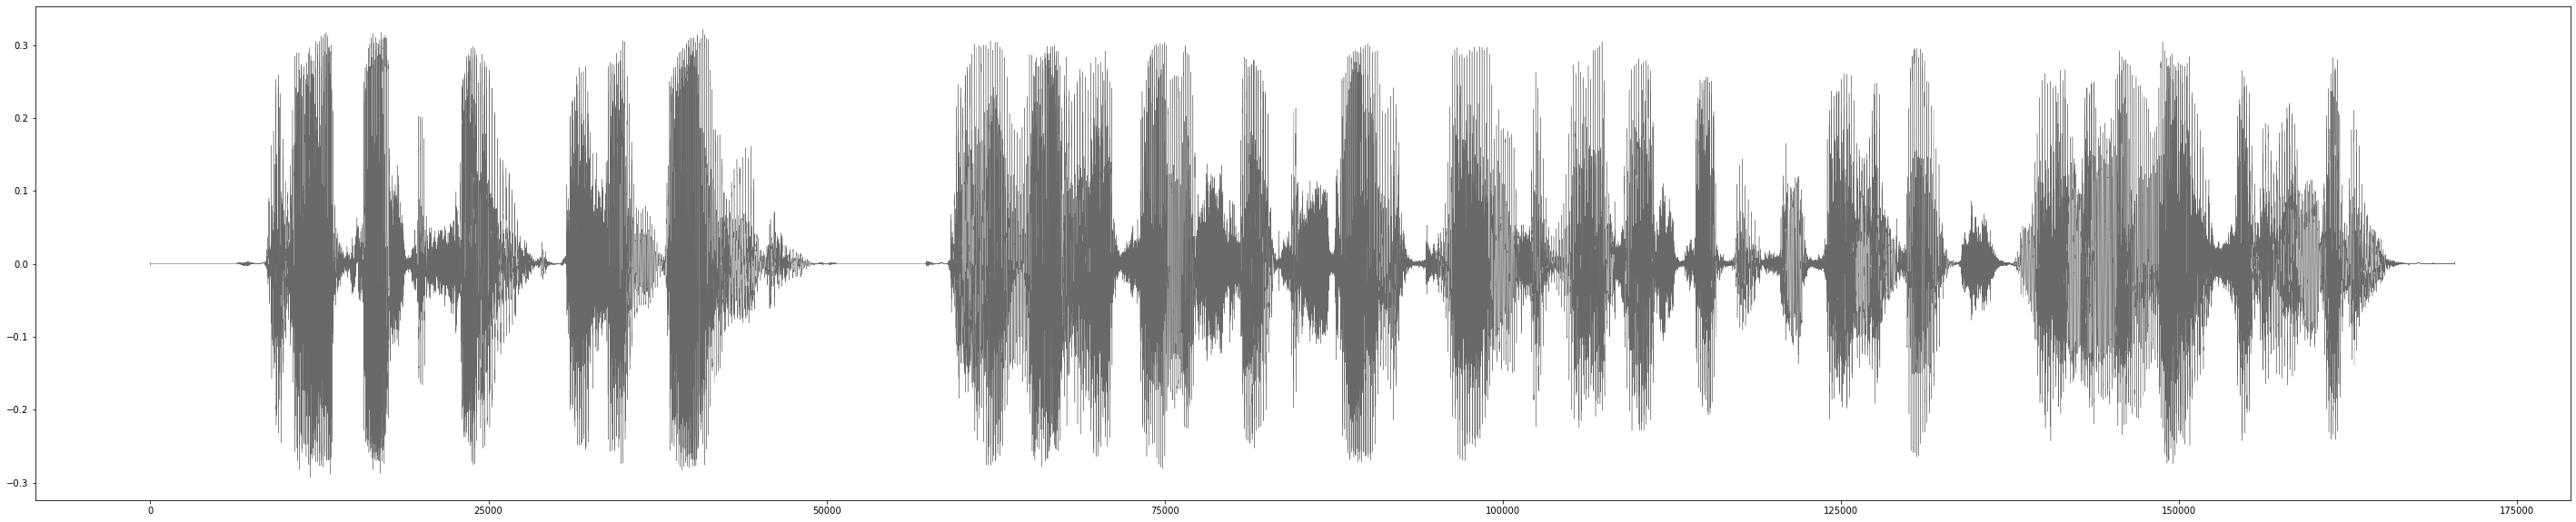

In [25]:
plot_curve((output.view(-1)).detach().numpy()) # time 1/2, feat 8

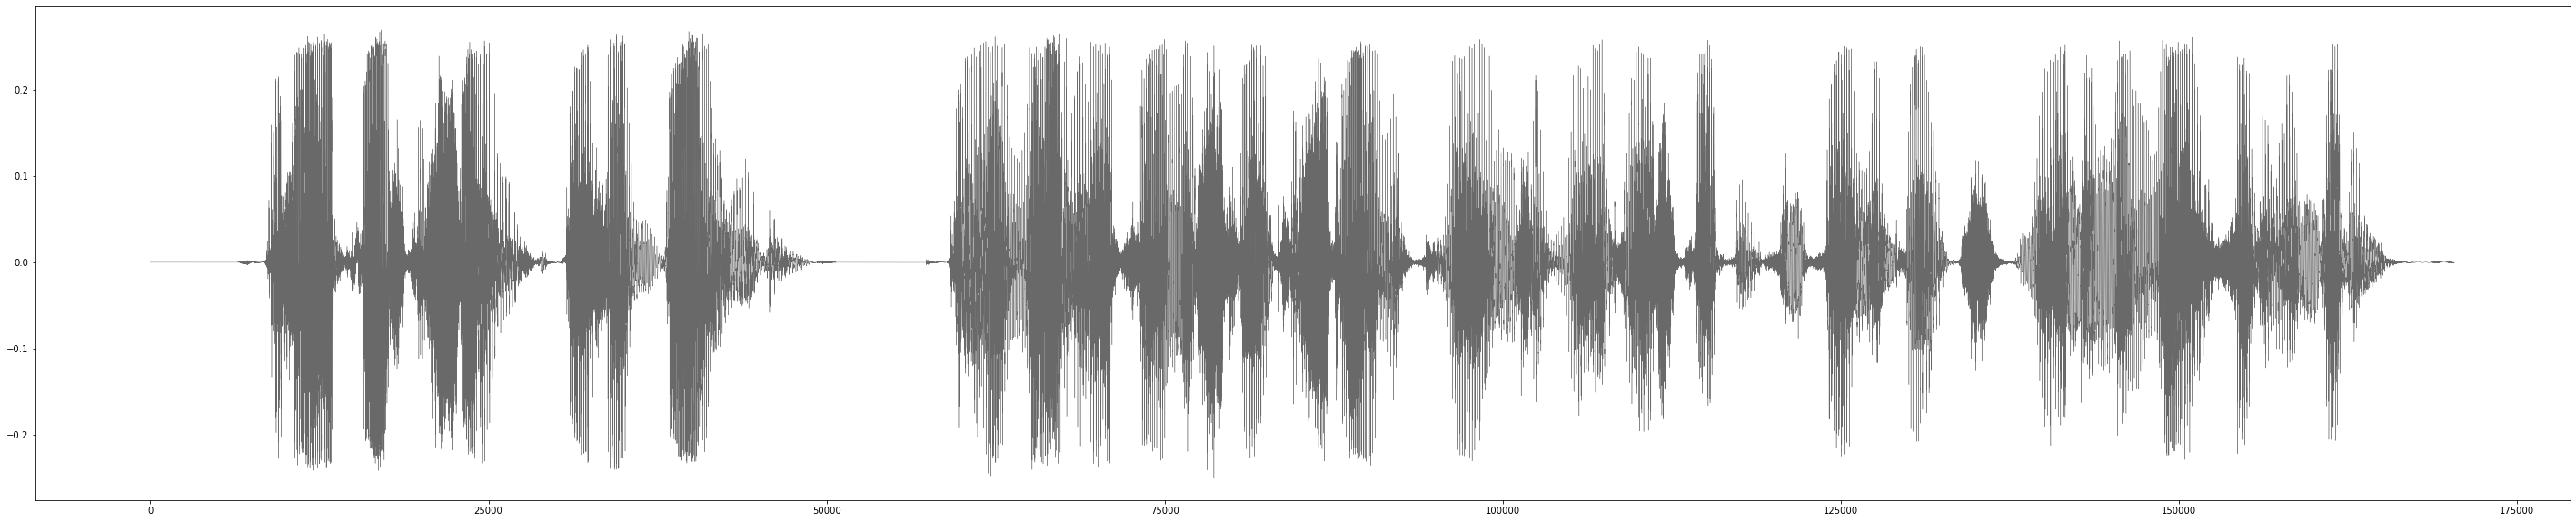

In [26]:
plot_curve((source.view(-1)).detach().numpy())

## 5. export  .flac Audio File

In [14]:
x_ = x_ * 3

In [137]:
sf.write('A_0215_1act_t_div1_feat32_6dB.flac', x_.view(-1).detach().numpy(), 16000)

In [66]:
features.shape

torch.Size([1, 512, 1065])

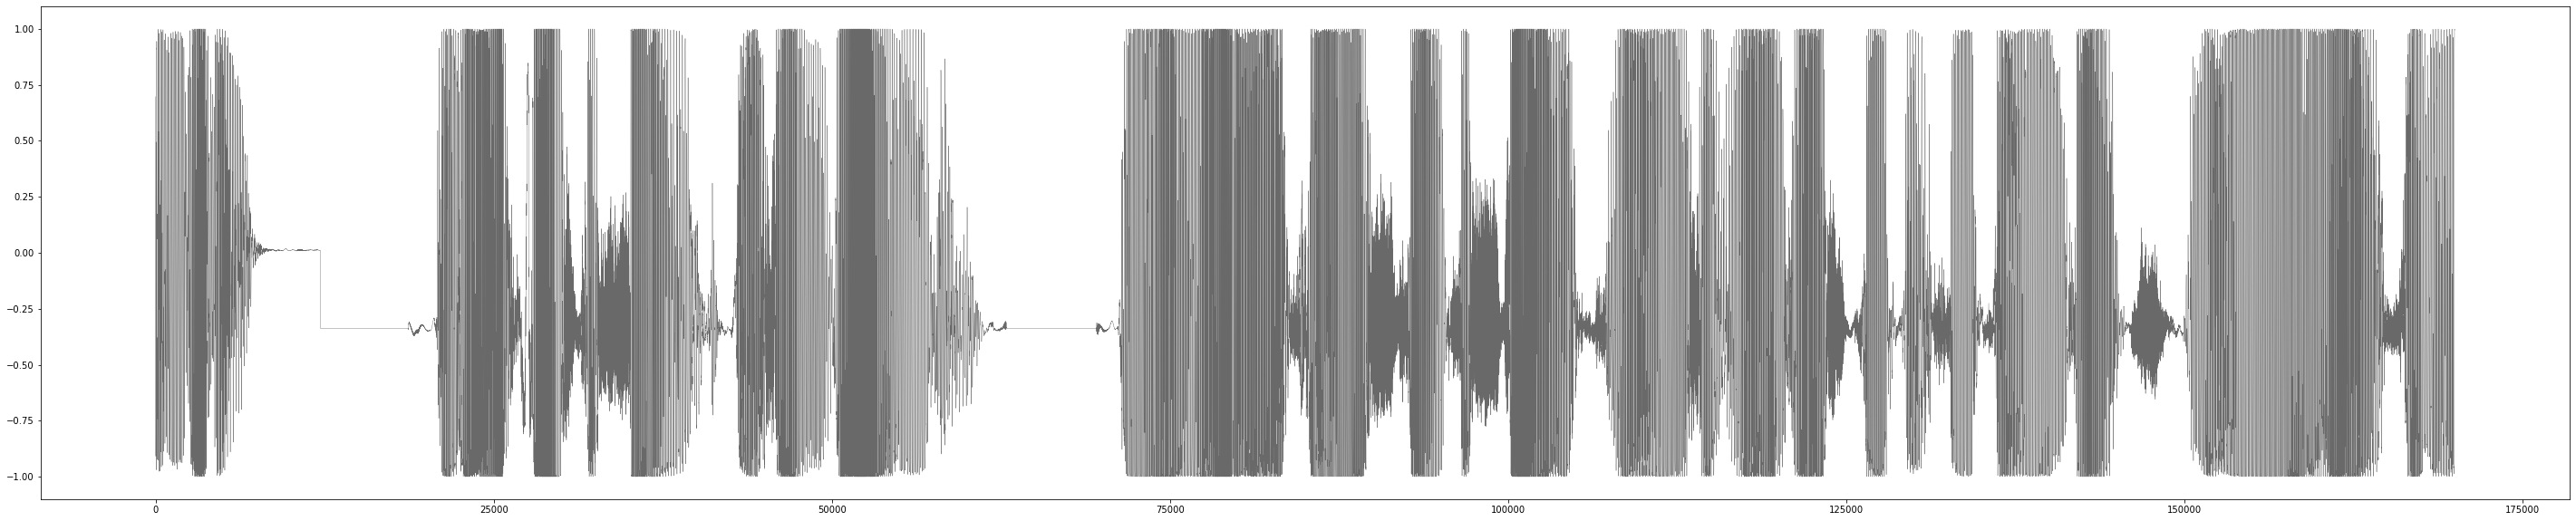

In [158]:
plot_curve((features_.view(-1)[5270000:5440000]).detach().numpy())

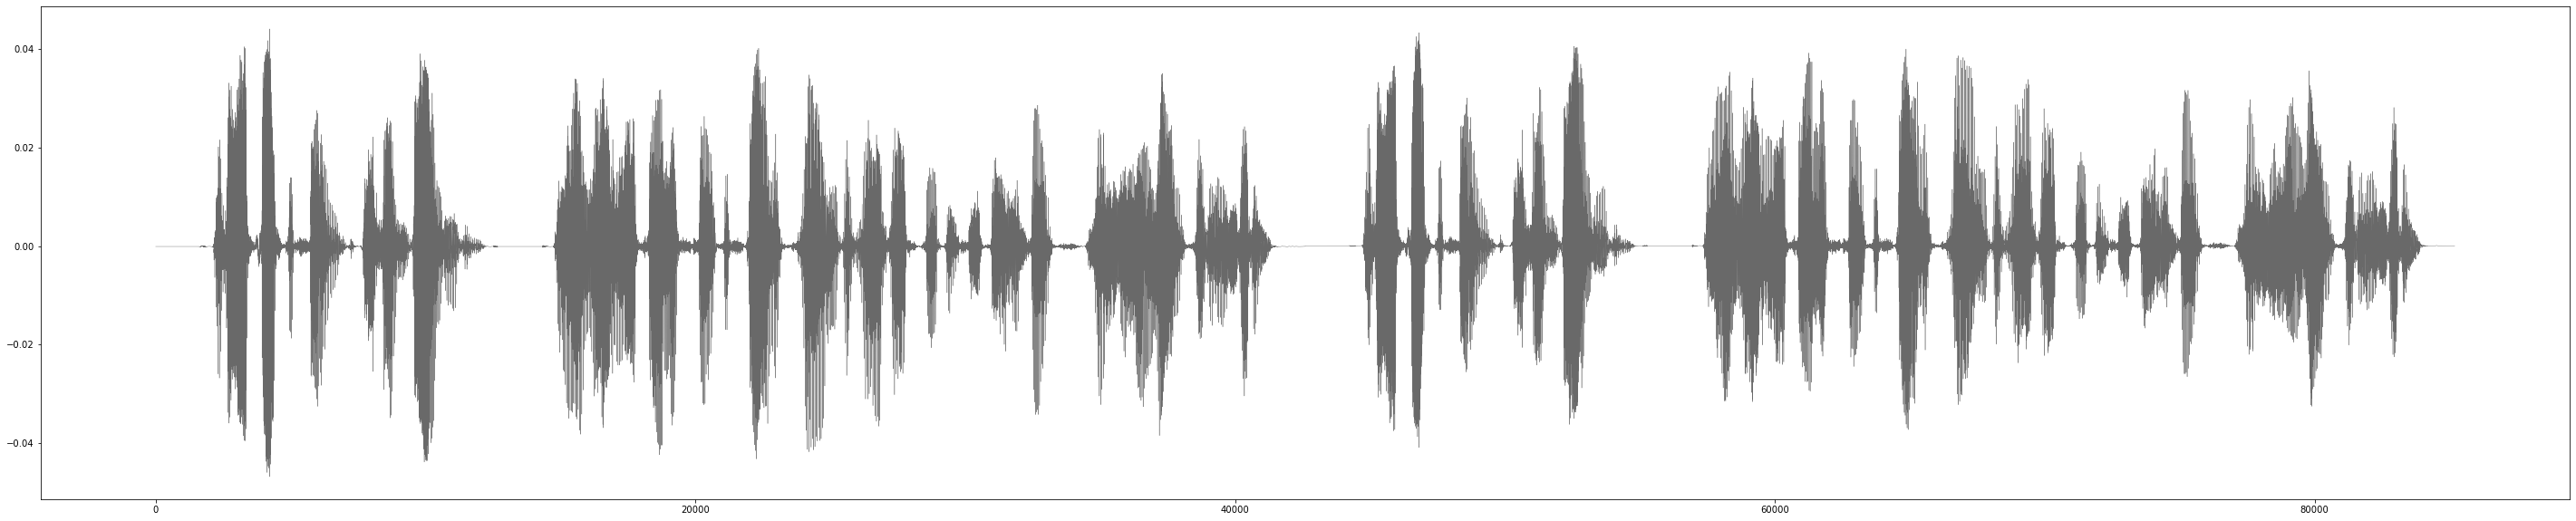

In [46]:
plot_curve((T_a_.view(-1)[:170000]).detach().numpy())

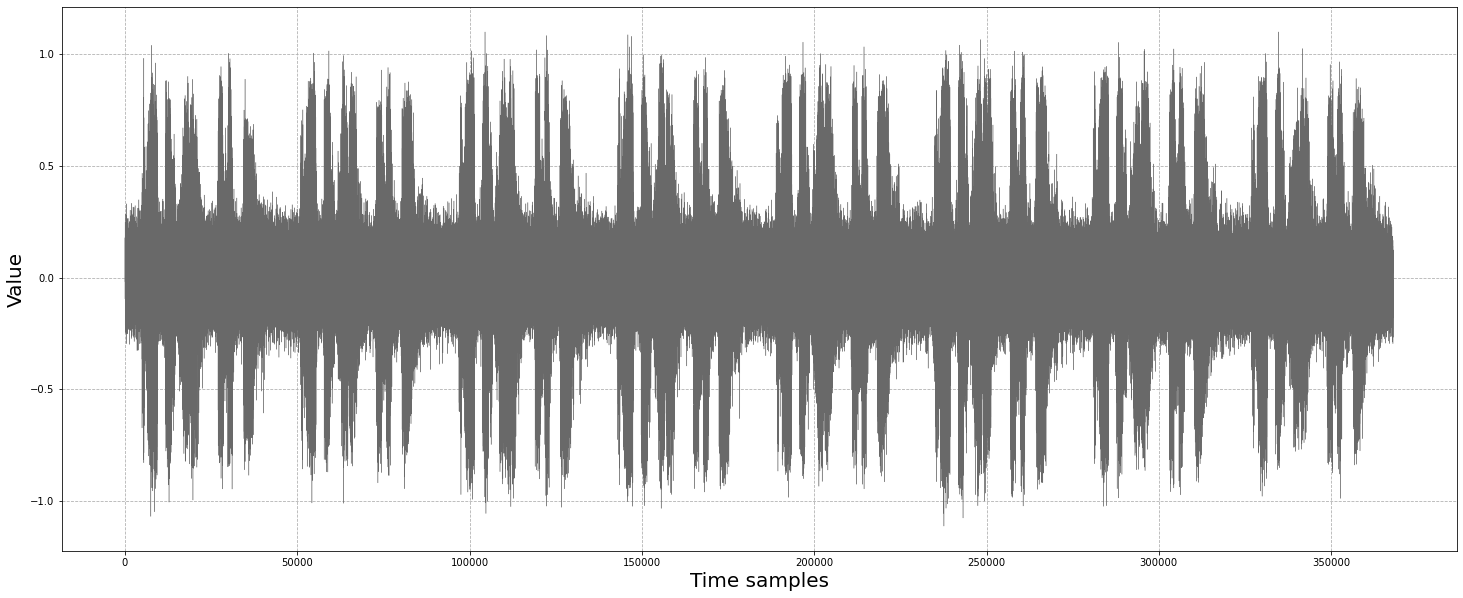

In [670]:
save_curve((Y[0][range(8),4000:50000].view(-1)).detach().numpy(),'fig_received.eps')

In [724]:
plot_curve((_X_.view(-1)).detach().numpy())

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

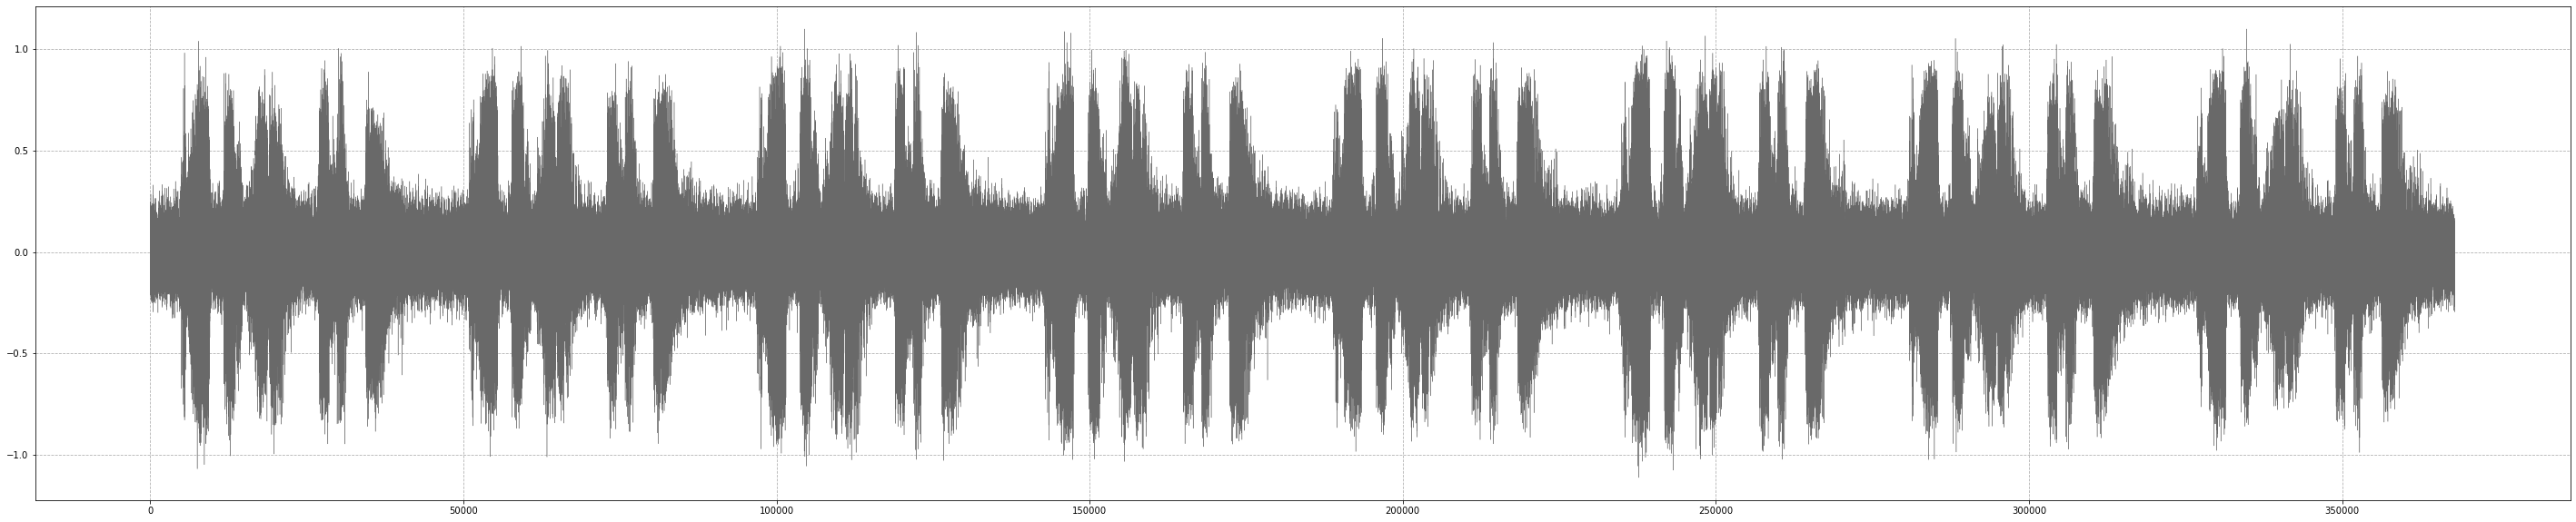

In [667]:
plot_curve((Y[0][range(8),4000:50000].view(-1)).detach().numpy())

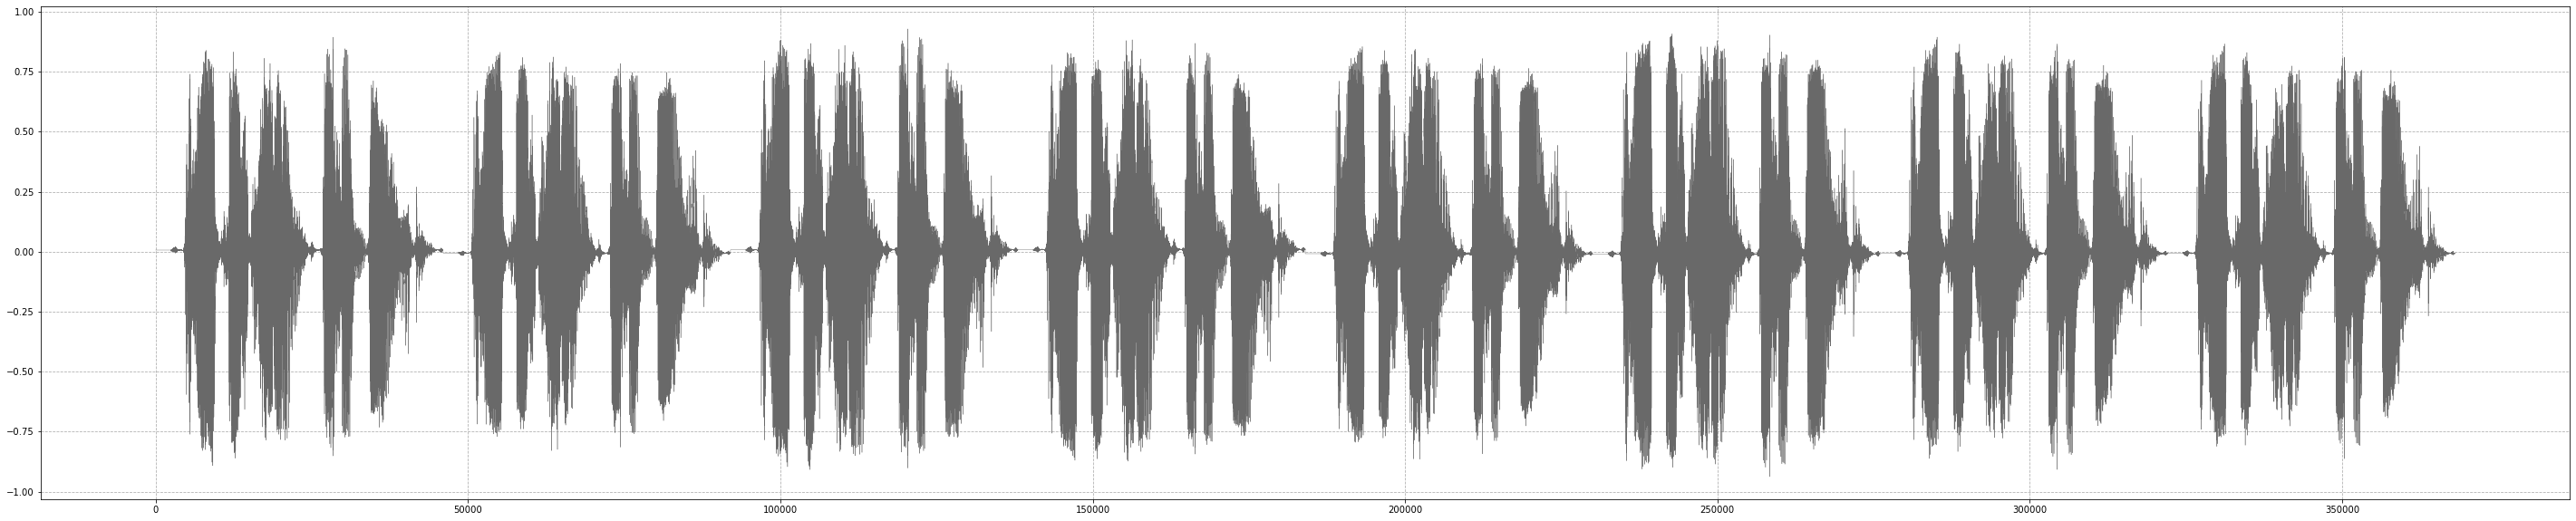

In [665]:
plot_curve((X[0][range(8),4000:50000].view(-1)).detach().numpy())

In [727]:
_X_.t().shape

torch.Size([110, 8])

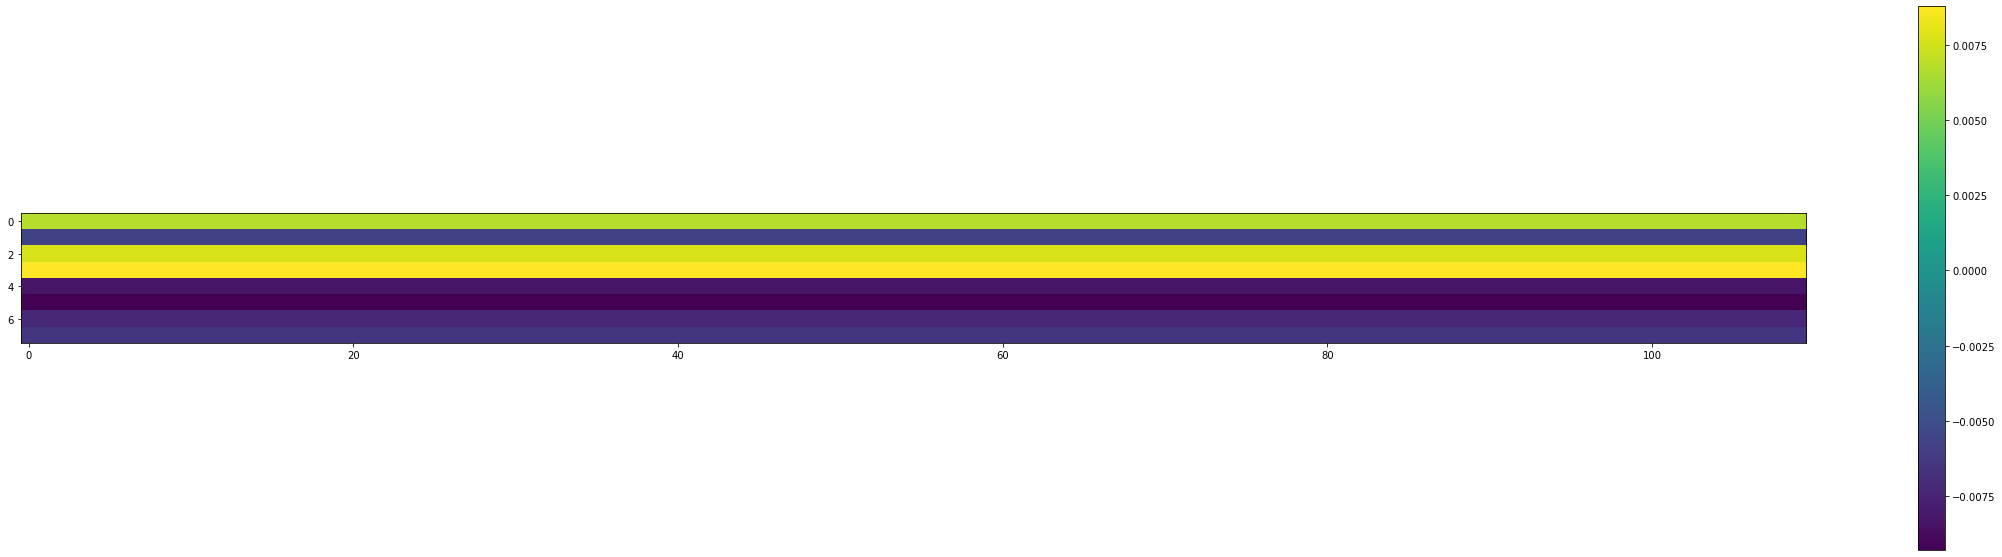

In [728]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import numpy as np
# x, y = np.random.rand(10), np.random.rand(10)
# z = (np.random.rand(9000000)+np.linspace(0,1, 9000000)).reshape(3000, 3000)

_X_ = X[0,range(8),4000:5100:10]
plt.imshow(_X_.detach().numpy())
#  \   norm=LogNorm(0.1))
plt.rcParams['figure.figsize'] = (40.0, 10.0) # 设置figure_size尺寸

plt.colorbar()
plt.show()

In [664]:
X[0][range(8),4000:50000].shape

torch.Size([8, 46000])

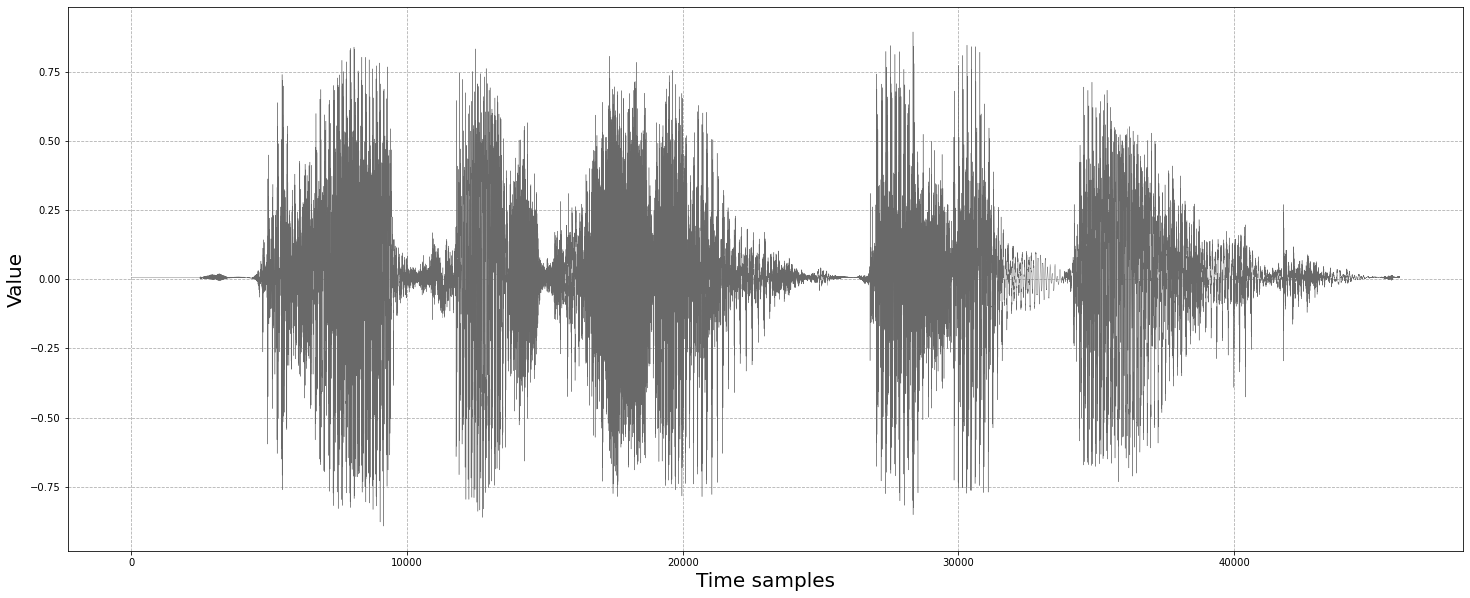

In [638]:
save_curve((X[:,:,].view(-1)).detach().numpy(),'fig_transmitted.eps')

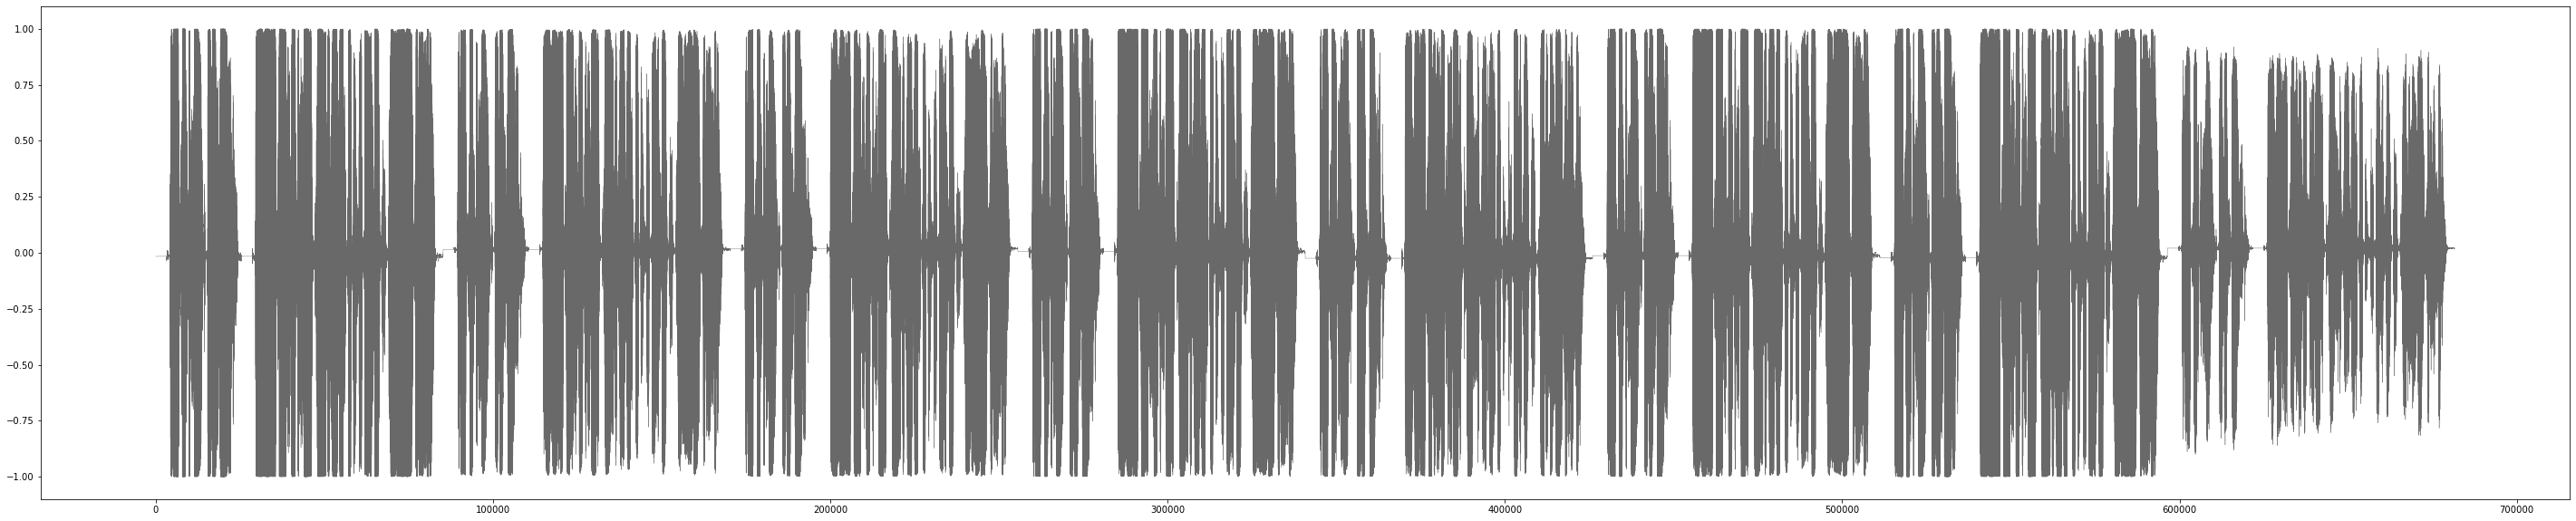

In [13]:
plot_curve((T_a_.view(-1)).detach().numpy())

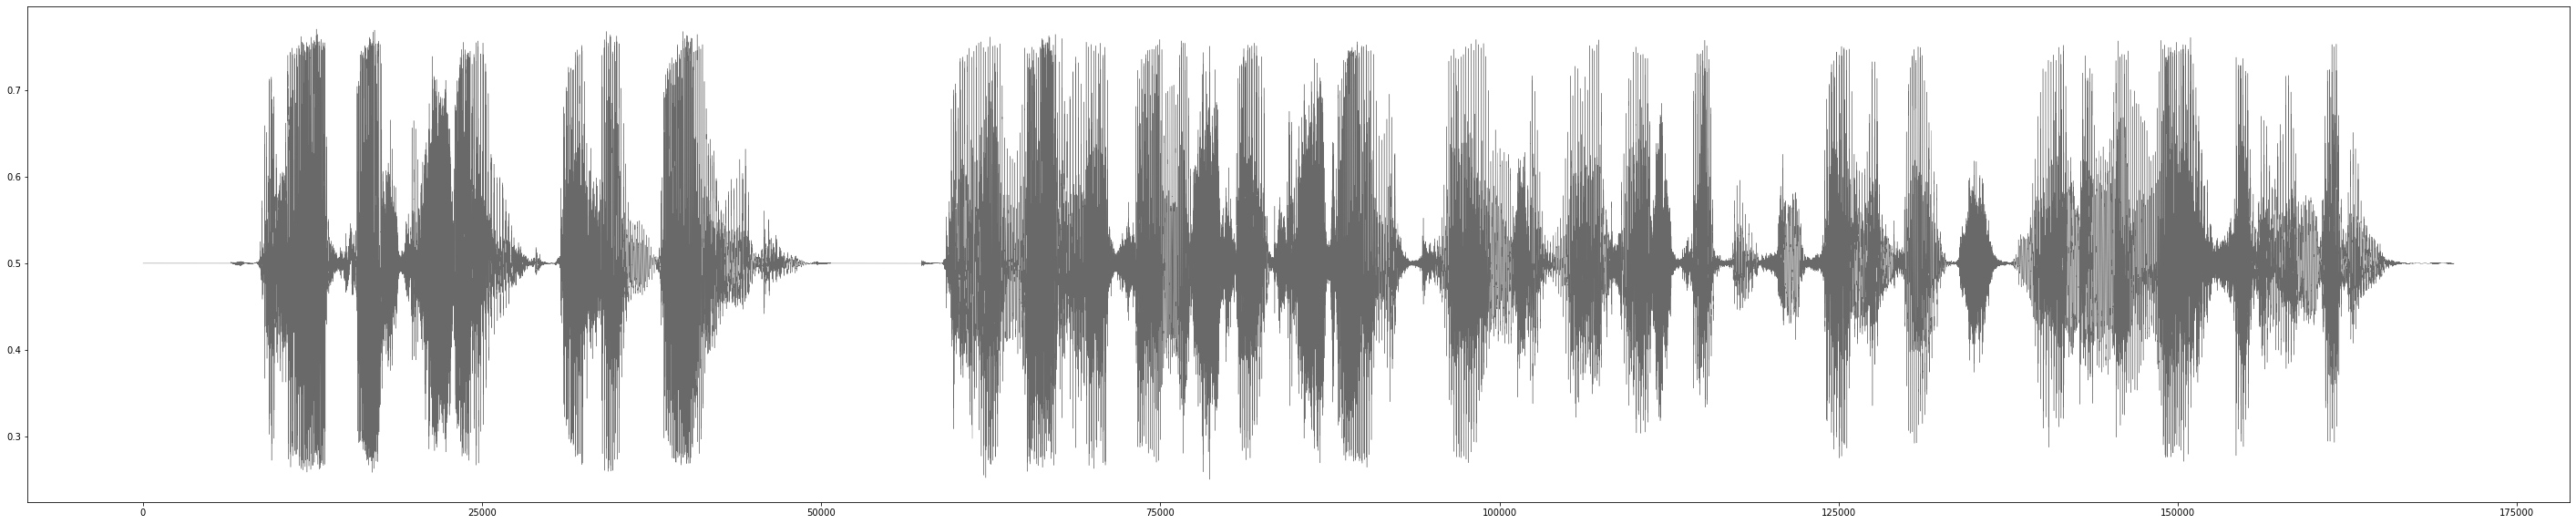

In [33]:
plot_curve((source_.view(-1)).detach().numpy())

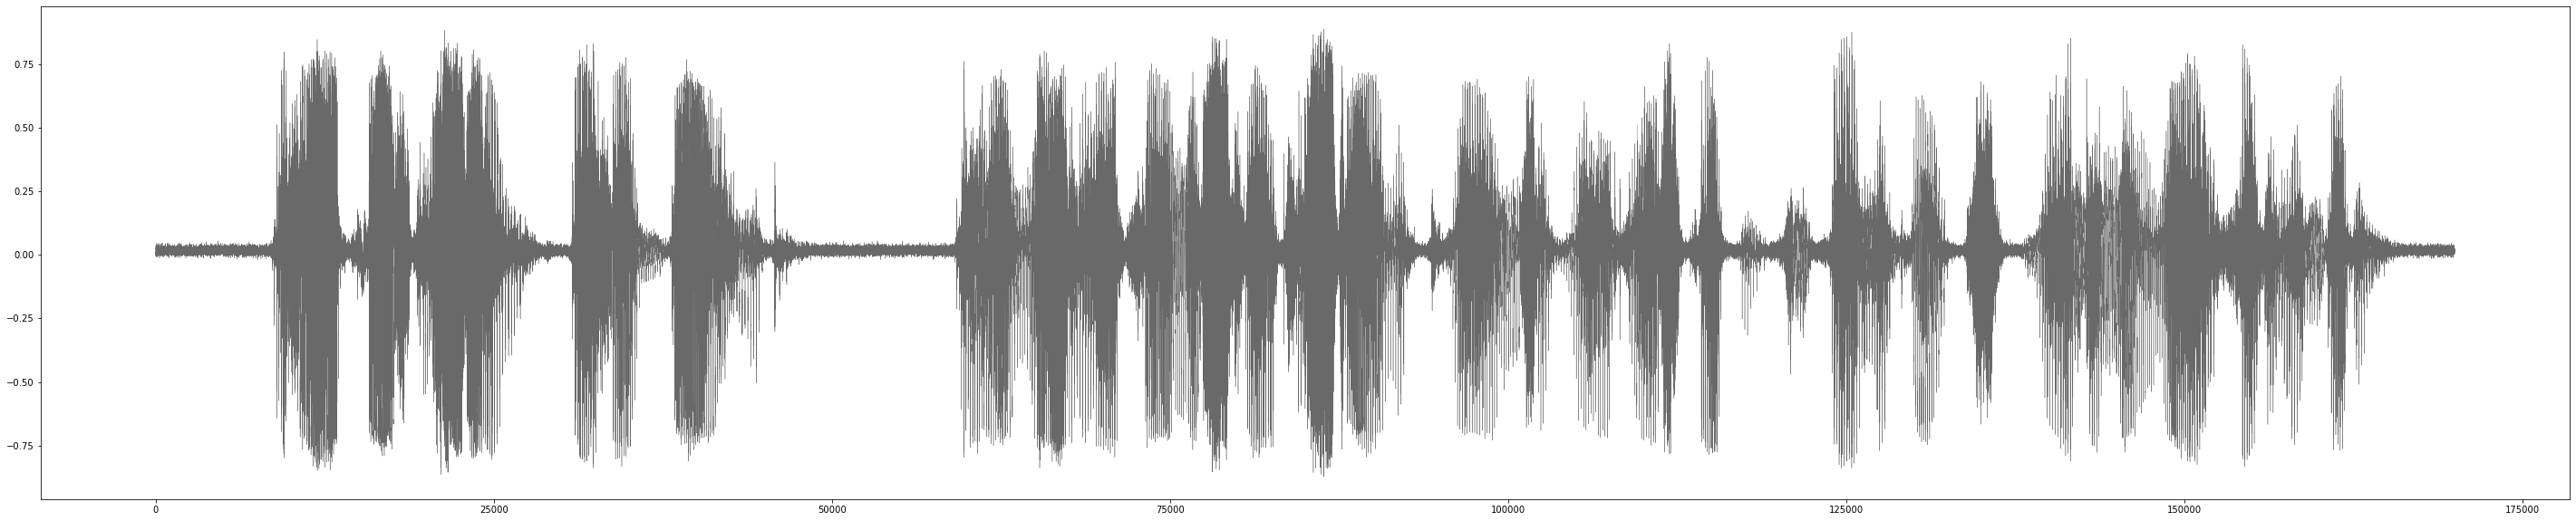

In [395]:
plot_curve((features.view(-1)[:170000]).detach().numpy())

In [79]:
len(x_.view(-1))

170394

In [71]:
source.mul(source).mean()

tensor(0.0038)

### Federated Learning

In [ ]:
# ./w2v_thn/decoder/0118like_en_arch/checkpoint_last.pt
# './w2v_thn/0119_big_lr/checkpoint_best.pt'
# './w2v_thn/decoder/0119_big_lr_small_sample/checkpoint_last.pt'
cp = torch.load('./w2v_thn/decoder/0221_1_act_tanh_time_div4_feat8_6dB_MSE/checkpoint_best.pt')
model = Wav2VecAutoEncoderModel.build_model(cp['cfg']['model'], task=None)
# model.load_state_dict(cp['model'])


In [999]:
para = cp['model']

In [1000]:
para 

OrderedDict([('feature_extractor.conv_layers.0.0.weight',
              tensor([[[ 2.0776e-01],
                       [-1.3574e-01],
                       [ 7.0305e-03],
                       [ 5.4291e-02],
                       [-8.3984e-02],
                       [ 1.9214e-01],
                       [-1.7731e-02],
                       [ 5.4169e-02]],
              
                      [[ 1.6553e-01],
                       [-1.0535e-01],
                       [ 2.0618e-03],
                       [-2.8320e-02],
                       [ 3.1958e-01],
                       [-2.0569e-02],
                       [ 4.2908e-02],
                       [ 2.1045e-01]],
              
                      [[-1.8604e-01],
                       [-1.8097e-02],
                       [ 1.2672e-02],
                       [ 1.8445e-01],
                       [-3.0005e-01],
                       [-2.5000e-01],
                       [-1.4478e-01],
                       [-1.4819e-01]

In [998]:
para['feature_extractor.conv_layers.0.0.weight'].shape

torch.Size([8, 8, 1])

In [1001]:
def fl_two(m1: str, m2:str):
    cp1 = torch.load(m1)
    cp2 = torch.load(m2)
    model1 = Wav2VecAutoEncoderModel.build_model(cp1['cfg']['model'], task=None)
    model2 = Wav2VecAutoEncoderModel.build_model(cp2['cfg']['model'], task=None)
    
    para1 = cp1['model']
    para2 = cp2['model']
    
    for key in para1.keys():
        para1[key] = (para1[key] + para2[key]) / 2
    
    cp3 = cp1
    cp3['model'] = para1
    
    model = Wav2VecAutoEncoderModel.build_model(cp['cfg']['model'], task=None)
    return model
    
#     model3 = 
    
    
    

In [1014]:
model_FLed = fl_two('./w2v_thn/decoder/0218_1_act_tanh_time_div1_feat8_6dB/checkpoint_best.pt', \
                   './w2v_thn/decoder/0218_1_act_tanh_time_div1_feat8_6dB_MSE/checkpoint_best.pt')

In [1013]:
model_FLed.feature_extractor

ConvFeatureExtractionModel(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): ConvTranspose1d(8, 8, kernel_size=(1,), stride=(1,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): Fp32GroupNorm(1, 8, eps=1e-05, affine=True)
    )
    (1): Sequential(
      (0): ConvTranspose1d(8, 8, kernel_size=(2,), stride=(2,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): Fp32GroupNorm(1, 8, eps=1e-05, affine=True)
    )
    (2): Sequential(
      (0): ConvTranspose1d(8, 8, kernel_size=(4,), stride=(2,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): Fp32GroupNorm(1, 8, eps=1e-05, affine=True)
    )
    (3): Sequential(
      (0): ConvTranspose1d(8, 1, kernel_size=(1,), stride=(1,), bias=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): Tanh()
    )
  )
)

### Test NRMSE

In [331]:
def NRMSE(output: torch.tensor, source: torch.tensor):
    import torch 
    loss_func = torch.nn.MSELoss(reduce=True, size_average=True)
    output, source = output.view(-1), source.view(-1)
    min_len = min(len(output), len(source))
    print("output, source, minlen=", len(output), len(source), min_len)
    loss = loss_func(output[:min_len], source[:min_len]) #/ source.mul(source).mean() #
    print("%.8f"%loss)
    return "%.8f"%loss
    

In [332]:
NRMSE(x_, source) # has noise 

output, source, minlen= 170403 170400 170400
0.00091482


'0.00091482'

In [299]:
NRMSE(x_[:,:,:] * 2, source) # no noise

output, source, minlen= 170403 170400 170400
tensor(8.4348e-05, grad_fn=<MseLossBackward>)


tensor(8.4348e-05, grad_fn=<MseLossBackward>)

In [262]:
x_[:,:,1]

tensor([[0.0049]], grad_fn=<SelectBackward>)

In [261]:
source[0]

tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.0002, -0.0002, -0.0002])

In [235]:
NRMSE(x_ *3, source) # no noise

output, source, minlen= 170403 170400 170400
tensor(0.0008, grad_fn=<MseLossBackward>)


tensor(0.0008, grad_fn=<MseLossBackward>)

In [234]:
NRMSE(x_ *2.6, source) # no noise

output, source, minlen= 170403 170400 170400
tensor(0.0005, grad_fn=<MseLossBackward>)


tensor(0.0005, grad_fn=<MseLossBackward>)